In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

We first consider the simple SIS model.

In [232]:
def dy_dt(t, y, beta, gamma):
    dS_dt = -beta*y[0]*y[1] + gamma*y[1]
    dI_dt = -dS_dt
    return np.array([dS_dt, dI_dt])

T = 70
i0 = 0.01
n_points = 1000
beta = 0.9
gamma = 0.3

solution = solve_ivp(fun=dy_dt, y0=(1-i0, i0), args=(beta, gamma),
                     t_span=(0,T), t_eval=np.linspace(0,T,n_points))

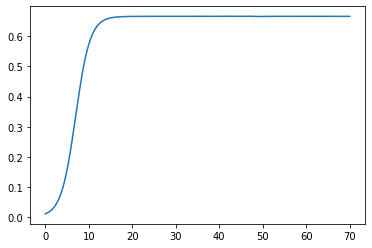

In [233]:
plt.plot(solution.t, solution.y[1])
#plt.axhline(1-gamma/beta)

In [243]:
def gillespie_sis(graph, beta, gamma, I0, T):
    
    # Initialize the model
    S = graph.number_of_nodes() - I0
    I = I0
    t = 0

    # Assign initial infected nodes randomly
    infected_nodes = set(np.random.choice(graph.nodes, size=I0, replace=False))
    nx.set_node_attributes(graph, values=dict.fromkeys(infected_nodes, 'i'), name='status')
    nx.set_node_attributes(graph, values=dict.fromkeys(graph.nodes-infected_nodes, 's'), name='status')
    
    # Find the susceptible neighbors
    susceptible_neighbors = {
        infected_node: {neighbor for neighbor in graph.neighbors(infected_node)
                        if graph.nodes[neighbor]["status"] != "i"}
        for infected_node in infected_nodes
    }
    infected_nodes = {infected_node: len(susceptible_neighbors[infected_node]) for infected_node in infected_nodes}
    N_SI = sum([infected_nodes[infected_node] for infected_node in infected_nodes])

    # Initialize the results list
    results = [(t, S, I)]

    # Main loop
    while t < T and I > 0:
        # Calculate the propensities of events
        print('t = {:.2f}'.format(t), end="\r")
        a1 = beta * N_SI
        a2 = gamma * I
        a0 = a1 + a2

        # Terminate if no more events can occur
        if a0 == 0:
            break

        # Generate two random numbers
        r1, r2 = np.random.rand(2)

        # Determine the time to the next event
        dt = -np.log(r1) / a0
        t += dt

        # Determine which event occurs
        array_infected_nodes = np.array(list(infected_nodes.items()))
        if r2 < a1 / a0:
            # Infection event
            infected_node = np.random.choice(array_infected_nodes[:,0], 
                                             p=array_infected_nodes[:,1]/array_infected_nodes[:,1].sum())
            new_infected = np.random.choice(list(susceptible_neighbors[infected_node]))
            graph.nodes[new_infected]['status'] = 'i'
            infected_nodes[new_infected] = 0
            
            susceptible_neighbors[new_infected] = set()
            for neighbor in graph.neighbors(new_infected):
                if graph.nodes[neighbor]["status"] != 'i':
                    susceptible_neighbors[new_infected].add(neighbor)
                    infected_nodes[new_infected] += 1
                    N_SI += 1
                else:
                    susceptible_neighbors[neighbor].discard(new_infected)
                    infected_nodes[neighbor] -= 1
                    N_SI -= 1
                                
            S -= 1
            I += 1
        
        else:
            # Recovery event
            recovered_node = np.random.choice(array_infected_nodes[:,0])
            graph.nodes[recovered_node]["status"] = "s"
            infected_nodes.pop(recovered_node)
            
            for neighbor in graph.neighbors(recovered_node):
                if graph.nodes[neighbor]["status"] != 'i':
                    N_SI -= 1
                else:
                    susceptible_neighbors[neighbor].add(recovered_node)
                    infected_nodes[neighbor] += 1
                    N_SI += 1
                    
            S += 1
            I -= 1
                    
        results.append((t, S, I))

    return np.array(results)

In [244]:
network_power_scale = nx.barabasi_albert_graph(n=1000, m=20)
I0 = 10
results = gillespie_sis(network_power_scale, beta, gamma, I0, T)

621.9 3.0
667.8000000000001 3.3
701.1 3.5999999999999996
760.5 3.9
778.5 4.2
804.6 4.5
821.7 4.8
837.0 5.1
915.3000000000001 5.3999999999999995
939.6 5.7
954.0 6.0
1021.5 6.3
1126.8 6.6
1147.5 6.8999999999999995
1179.0 7.199999999999999
1225.8 7.5
1251.9 7.8
1266.3 8.1
1293.3 8.4
1314.0 8.7
1344.6000000000001 9.0
1369.8 9.299999999999999
1407.6000000000001 9.6
1430.1000000000001 9.9
1467.0 10.2
1487.7 10.5
1500.3 10.799999999999999
1614.6000000000001 11.1
1703.7 11.4
1818.0 11.7
1888.2 12.0
1901.7 12.299999999999999
1925.1000000000001 12.6
1947.6000000000001 12.9
2061.9 13.2
2084.4 13.5
2103.3 13.799999999999999
2283.3 14.1
2409.3 14.399999999999999
2534.4 14.7
2547.9 15.0
2580.3 15.299999999999999
2693.7000000000003 15.6
2764.8 15.899999999999999
2788.2000000000003 16.2
2859.3 16.5
2873.7000000000003 16.8
2891.7000000000003 17.099999999999998
2911.5 17.4
2934.9 17.7
2961.0 18.0
2985.3 18.3
3002.4 18.599999999999998
3020.4 18.9
3034.8 19.2
3095.1 19.5
3109.5 19.8
3156.3 20.099999999999

8537.4 111.89999999999999
8544.6 112.2
8548.2 112.5
8559.9 112.8
8566.2 113.1
8570.7 113.39999999999999
8565.300000000001 113.7
8565.300000000001 114.0
8559.9 114.3
8557.2 114.6
8555.4 114.89999999999999
8557.2 115.19999999999999
8553.6 115.5
8554.5 115.8
8558.1 116.1
8560.800000000001 116.39999999999999
8567.1 116.69999999999999
8566.2 117.0
8574.300000000001 117.3
8584.2 117.6
8584.2 117.89999999999999
8586.9 118.19999999999999
8601.300000000001 118.5
8608.5 118.8
8610.300000000001 119.1
8624.7 119.39999999999999
8621.1 119.69999999999999
8619.300000000001 120.0
8629.2 120.3
8625.6 120.6
8622.0 120.89999999999999
8630.1 121.19999999999999
8631.9 121.5
8637.300000000001 121.8
8634.6 122.1
8638.2 122.39999999999999
8638.2 122.69999999999999
8631.9 123.0
8633.7 123.3
8641.800000000001 123.6
8642.7 123.89999999999999
8631.9 124.19999999999999
8631.9 124.5
8637.300000000001 124.8
8647.2 125.1
8648.1 125.39999999999999
8652.6 125.69999999999999
8653.5 126.0
8649.0 126.3
8650.800000000001 1

6298.2 204.6
6292.8 204.9
6264.900000000001 205.2
6254.1 205.5
6240.6 205.79999999999998
6225.3 206.1
6183.0 206.4
6167.7 206.7
6156.900000000001 207.0
6148.8 207.29999999999998
6134.400000000001 207.6
6127.2 207.9
6115.5 208.2
6108.3 208.5
6094.8 208.79999999999998
6076.8 209.1
6036.3 209.4
6018.3 209.7
6001.2 210.0
5986.8 210.29999999999998
5998.5 210.0
5971.5 210.29999999999998
5956.2 210.6
5935.5 210.9
5922.900000000001 211.2
5907.6 211.5
5895.900000000001 211.79999999999998
5911.2 211.5
5900.400000000001 211.79999999999998
5891.400000000001 212.1
5880.6 212.4
5859.0 212.7
5841.900000000001 213.0
5828.400000000001 213.29999999999998
5802.3 213.6
5787.900000000001 213.9
5763.6 214.2
5749.2 214.5
5704.2 214.79999999999998
5679.900000000001 215.1
5671.8 215.4
5634.0 215.7
5688.0 215.4
5679.0 215.7
5643.900000000001 216.0
5625.900000000001 216.29999999999998
5613.3 216.6
5593.5 216.9
5576.400000000001 217.2
5566.5 217.5
5541.3 217.79999999999998
5536.8 218.1
5520.6 218.4
5493.6 218.7
5

283.5 297.0
256.5 297.3
295.2 297.0
333.90000000000003 296.7
315.0 297.0
274.5 297.3
235.8 297.59999999999997
204.3 297.9
180.9 298.2
198.9 297.9
180.9 298.2
199.8 297.9
225.9 297.59999999999997
199.8 297.9
140.4 298.2
158.4 297.9
176.4 297.59999999999997
154.8 297.9
193.5 297.59999999999997
154.8 297.9
172.8 297.59999999999997
216.9 297.3
198.9 297.59999999999997
154.8 297.9
172.8 297.59999999999997
154.8 297.9
136.8 298.2
156.6 297.9
180.9 297.59999999999997
211.5 297.3
229.5 297.0
205.20000000000002 297.3
301.5 297.0
261.90000000000003 297.3
289.8 297.0
308.7 296.7
380.7 296.4
308.7 296.7
334.8 296.4
369.0 296.09999999999997
352.8 296.4
420.3 296.09999999999997
322.2 296.4
342.90000000000003 296.09999999999997
365.40000000000003 295.8
337.5 296.09999999999997
320.40000000000003 296.4
302.40000000000003 296.7
281.7 297.0
303.3 296.7
338.40000000000003 296.4
408.6 296.09999999999997
444.6 295.8
470.7 295.5
401.40000000000003 295.8
437.40000000000003 295.5
405.0 295.8
369.9000000000000

211.5 297.59999999999997
173.70000000000002 297.9
195.3 297.59999999999997
241.20000000000002 297.3
195.3 297.59999999999997
225.0 297.3
192.6 297.59999999999997
216.0 297.3
250.20000000000002 297.0
225.0 297.3
203.4 297.59999999999997
171.9 297.9
189.9 297.59999999999997
210.6 297.3
189.9 297.59999999999997
214.20000000000002 297.3
235.8 297.0
201.6 297.3
178.20000000000002 297.59999999999997
196.20000000000002 297.3
284.40000000000003 297.0
303.3 296.7
215.1 297.0
196.20000000000002 297.3
166.5 297.59999999999997
144.9 297.9
124.2 298.2
101.7 298.5
118.8 298.2
137.70000000000002 297.9
170.1 297.59999999999997
204.3 297.3
184.5 297.59999999999997
215.1 297.3
193.5 297.59999999999997
252.0 297.3
193.5 297.59999999999997
162.9 297.9
128.70000000000002 298.2
106.2 298.5
182.70000000000002 298.2
164.70000000000002 298.5
194.4 298.2
224.1 297.9
147.6 298.2
115.2 298.5
188.1 298.2
207.9 297.9
135.0 298.2
117.9 298.5
327.6 298.2
117.9 298.5
277.2 298.2
308.7 297.9
279.0 298.2
119.7 298.5
138

346.5 297.0
247.5 297.3
269.1 297.0
248.4 297.3
226.8 297.59999999999997
255.6 297.3
224.1 297.59999999999997
206.1 297.9
144.0 298.2
115.2 298.5
176.4 298.2
150.3 298.5
89.10000000000001 298.8
108.9 298.5
126.9 298.2
108.0 298.5
127.8 298.2
146.70000000000002 297.9
167.4 297.59999999999997
186.3 297.3
166.5 297.59999999999997
212.4 297.3
193.5 297.59999999999997
215.1 297.3
196.20000000000002 297.59999999999997
220.5 297.3
244.8 297.0
216.0 297.3
197.1 297.59999999999997
215.1 297.3
247.5 297.0
268.2 296.7
298.8 296.4
316.8 296.09999999999997
372.6 295.8
342.0 296.09999999999997
360.90000000000003 295.8
378.90000000000003 295.5
425.7 295.2
462.6 294.9
417.6 295.2
438.3 294.9
466.2 294.59999999999997
445.5 294.9
468.0 294.59999999999997
445.5 294.9
417.6 295.2
399.6 295.5
428.40000000000003 295.2
459.0 294.9
403.2 295.2
385.2 295.5
413.1 295.2
365.40000000000003 295.5
390.6 295.2
369.90000000000003 295.5
389.7 295.2
531.0 294.9
580.5 294.59999999999997
560.7 294.9
419.40000000000003 29

523.8000000000001 294.3
499.5 294.59999999999997
479.7 294.9
443.7 295.2
486.90000000000003 294.9
509.40000000000003 294.59999999999997
491.40000000000003 294.9
471.6 295.2
489.6 294.9
468.0 295.2
449.1 295.5
520.2 295.2
438.3 295.5
402.3 295.8
437.40000000000003 295.5
413.1 295.8
433.8 295.5
477.0 295.2
455.40000000000003 295.5
478.8 295.2
500.40000000000003 294.9
468.90000000000003 295.2
493.2 294.9
423.90000000000003 295.2
447.3 294.9
418.5 295.2
394.2 295.5
440.1 295.2
421.2 295.5
379.8 295.8
332.1 296.09999999999997
426.6 295.8
451.8 295.5
429.3 295.8
468.0 295.5
448.2 295.8
426.6 296.09999999999997
407.7 296.4
561.6 296.09999999999997
543.6 296.4
387.90000000000003 296.7
354.6 297.0
258.3 297.3
334.8 297.0
358.2 296.7
385.2 296.4
342.0 296.7
364.5 296.4
289.8 296.7
266.40000000000003 297.0
285.3 296.7
262.8 297.0
280.8 296.7
305.1 296.4
279.90000000000003 296.7
258.3 297.0
277.2 296.7
232.20000000000002 297.0
208.8 297.3
233.1 297.0
208.8 297.3
178.20000000000002 297.599999999999

251.1 297.9
273.6 297.59999999999997
217.8 297.9
184.5 298.2
166.5 298.5
187.20000000000002 298.2
284.40000000000003 297.9
251.1 298.2
277.2 297.9
225.9 298.2
247.5 297.9
267.3 297.59999999999997
330.3 297.3
352.8 297.0
376.2 296.7
355.5 297.0
395.1 296.7
355.5 297.0
292.5 297.3
266.40000000000003 297.59999999999997
169.20000000000002 297.9
378.90000000000003 297.59999999999997
169.20000000000002 297.9
196.20000000000002 297.59999999999997
214.20000000000002 297.3
177.3 297.59999999999997
155.70000000000002 297.9
193.5 297.59999999999997
211.5 297.3
189.0 297.59999999999997
207.0 297.3
239.4 297.0
270.0 296.7
302.40000000000003 296.4
271.8 296.7
253.8 297.0
221.4 297.3
241.20000000000002 297.0
220.5 297.3
243.9 297.0
211.5 297.3
189.0 297.59999999999997
169.20000000000002 297.9
192.6 297.59999999999997
219.6 297.3
240.3 297.0
219.6 297.3
196.20000000000002 297.59999999999997
178.20000000000002 297.9
204.3 297.59999999999997
236.70000000000002 297.3
207.9 297.59999999999997
231.3 297.3


243.0 297.59999999999997
310.5 297.3
278.1 297.59999999999997
260.1 297.9
324.90000000000003 297.59999999999997
289.8 297.9
349.2 297.59999999999997
396.90000000000003 297.3
435.6 297.0
370.8 297.3
303.3 297.59999999999997
280.8 297.9
312.3 297.59999999999997
280.8 297.9
298.8 297.59999999999997
317.7 297.3
279.0 297.59999999999997
261.0 297.9
232.20000000000002 298.2
252.0 297.9
297.90000000000003 297.59999999999997
247.5 297.9
265.5 297.59999999999997
235.8 297.9
318.6 297.59999999999997
269.1 297.9
186.3 298.2
207.9 297.9
148.5 298.2
168.3 297.9
187.20000000000002 297.59999999999997
162.9 297.9
198.0 297.59999999999997
178.20000000000002 297.9
202.5 297.59999999999997
227.70000000000002 297.3
207.9 297.59999999999997
189.0 297.9
219.6 297.59999999999997
248.4 297.3
269.1 297.0
307.8 296.7
325.8 296.4
352.8 296.09999999999997
334.8 296.4
314.1 296.7
518.4 296.4
314.1 296.7
333.0 296.4
357.3 296.09999999999997
326.7 296.4
356.40000000000003 296.09999999999997
332.1 296.4
353.7 296.099

333.90000000000003 297.0
261.90000000000003 297.3
242.1 297.59999999999997
265.5 297.3
229.5 297.59999999999997
249.3 297.3
192.6 297.59999999999997
222.3 297.3
198.9 297.59999999999997
226.8 297.3
249.3 297.0
229.5 297.3
251.1 297.0
232.20000000000002 297.3
207.0 297.59999999999997
180.9 297.9
149.4 298.2
171.9 297.9
189.9 297.59999999999997
167.4 297.9
198.9 297.59999999999997
217.8 297.3
196.20000000000002 297.59999999999997
231.3 297.3
248.4 297.0
278.1 296.7
260.1 297.0
232.20000000000002 297.3
250.20000000000002 297.0
218.70000000000002 297.3
244.8 297.0
270.90000000000003 296.7
241.20000000000002 297.0
270.90000000000003 296.7
293.40000000000003 296.4
270.90000000000003 296.7
296.1 296.4
270.0 296.7
288.90000000000003 296.4
340.2 296.09999999999997
358.2 295.8
386.1 295.5
409.5 295.2
468.90000000000003 294.9
547.2 294.59999999999997
468.90000000000003 294.9
510.3 294.59999999999997
459.0 294.9
436.5 295.2
417.6 295.5
394.2 295.8
364.5 296.09999999999997
396.0 295.8
423.0 295.5
3

305.1 296.09999999999997
368.1 295.8
342.0 296.09999999999997
322.2 296.4
342.90000000000003 296.09999999999997
371.7 295.8
346.5 296.09999999999997
317.7 296.4
298.8 296.7
350.1 296.4
287.1 296.7
338.40000000000003 296.4
287.1 296.7
265.5 297.0
243.9 297.3
268.2 297.0
288.0 296.7
313.2 296.4
293.40000000000003 296.7
312.3 296.4
287.1 296.7
266.40000000000003 297.0
244.8 297.3
221.4 297.59999999999997
249.3 297.3
273.6 297.0
245.70000000000002 297.3
268.2 297.0
243.9 297.3
268.2 297.0
218.70000000000002 297.3
256.5 297.0
234.0 297.3
216.0 297.59999999999997
242.1 297.3
267.3 297.0
362.7 296.7
267.3 297.0
308.7 296.7
267.3 297.0
229.5 297.3
178.20000000000002 297.59999999999997
228.6 297.3
252.9 297.0
234.0 297.3
209.70000000000002 297.59999999999997
184.5 297.9
132.3 298.2
166.5 297.9
192.6 297.59999999999997
215.1 297.3
190.8 297.59999999999997
164.70000000000002 297.9
275.40000000000003 297.59999999999997
251.1 297.9
299.7 297.59999999999997
279.90000000000003 297.9
308.7 297.5999999

230.4 297.3
261.0 297.0
232.20000000000002 297.3
255.6 297.0
275.40000000000003 296.7
295.2 296.4
316.8 296.09999999999997
291.6 296.4
261.0 296.7
239.4 297.0
218.70000000000002 297.3
240.3 297.0
218.70000000000002 297.3
242.1 297.0
263.7 296.7
288.0 296.4
306.0 296.09999999999997
398.7 295.8
376.2 296.09999999999997
283.5 296.4
259.2 296.7
279.90000000000003 296.4
372.6 296.09999999999997
338.40000000000003 296.4
317.7 296.7
225.0 297.0
256.5 296.7
288.90000000000003 296.4
307.8 296.09999999999997
283.5 296.4
309.6 296.09999999999997
332.1 295.8
306.0 296.09999999999997
324.0 295.8
307.8 296.09999999999997
342.0 295.8
367.2 295.5
333.90000000000003 295.8
299.7 296.09999999999997
281.7 296.4
319.5 296.09999999999997
297.90000000000003 296.4
362.7 296.09999999999997
381.6 295.8
400.5 295.5
504.0 295.2
530.1 294.9
556.2 294.59999999999997
522.0 294.9
501.3 295.2
591.3000000000001 294.9
528.3000000000001 295.2
590.4 294.9
571.5 295.2
469.8 295.5
378.0 295.8
356.40000000000003 296.09999999

151.20000000000002 298.2
181.8 297.9
159.3 298.2
137.70000000000002 298.5
167.4 298.2
189.0 297.9
226.8 297.59999999999997
438.3 297.3
226.8 297.59999999999997
358.2 297.3
322.2 297.59999999999997
189.0 297.9
151.20000000000002 298.2
193.5 297.9
217.8 297.59999999999997
185.4 297.9
203.4 297.59999999999997
173.70000000000002 297.9
259.2 297.59999999999997
216.9 297.9
131.4 298.2
150.3 297.9
173.70000000000002 297.59999999999997
154.8 297.9
174.6 297.59999999999997
192.6 297.3
169.20000000000002 297.59999999999997
188.1 297.3
207.9 297.0
229.5 296.7
211.5 297.0
242.1 296.7
275.40000000000003 296.4
256.5 296.7
276.3 296.4
252.0 296.7
232.20000000000002 297.0
210.6 297.3
186.3 297.59999999999997
163.8 297.9
186.3 297.59999999999997
166.5 297.9
146.70000000000002 298.2
241.20000000000002 297.9
265.5 297.59999999999997
171.0 297.9
135.9 298.2
111.60000000000001 298.5
135.9 298.2
161.1 297.9
342.90000000000003 297.59999999999997
312.3 297.9
387.0 297.59999999999997
406.8 297.3
225.0 297.5999

148.5 298.2
170.1 297.9
192.6 297.59999999999997
210.6 297.3
229.5 297.0
261.0 296.7
240.3 297.0
259.2 296.7
225.0 297.0
244.8 296.7
267.3 296.4
289.8 296.09999999999997
316.8 295.8
297.90000000000003 296.09999999999997
316.8 295.8
294.3 296.09999999999997
315.90000000000003 295.8
334.8 295.5
316.8 295.8
340.2 295.5
391.5 295.2
422.1 294.9
395.1 295.2
413.1 294.9
476.1 294.59999999999997
452.7 294.9
389.7 295.2
369.90000000000003 295.5
347.40000000000003 295.8
324.90000000000003 296.09999999999997
346.5 295.8
368.1 295.5
390.6 295.2
423.0 294.9
531.0 294.59999999999997
597.6 294.3
621.0 294.0
639.9 293.7
533.7 294.0
571.5 293.7
533.7 294.0
465.3 294.3
434.7 294.59999999999997
416.7 294.9
397.8 295.2
488.7 294.9
506.7 294.59999999999997
415.8 294.9
446.40000000000003 294.59999999999997
427.5 294.9
408.6 295.2
386.1 295.5
363.6 295.8
383.40000000000003 295.5
349.2 295.8
325.8 296.09999999999997
353.7 295.8
375.3 295.5
391.5 295.2
369.90000000000003 295.5
348.3 295.8
380.7 295.5
348.3 295

381.6 296.09999999999997
431.1 295.8
449.1 295.5
468.90000000000003 295.2
491.40000000000003 294.9
441.90000000000003 295.2
461.7 294.9
480.6 294.59999999999997
461.7 294.9
439.2 295.2
646.2 294.9
678.6 294.59999999999997
698.4 294.3
677.7 294.59999999999997
697.5 294.3
675.0 294.59999999999997
655.2 294.9
690.3000000000001 294.59999999999997
672.3000000000001 294.9
647.1 295.2
629.1 295.5
655.2 295.2
573.3000000000001 295.5
595.8000000000001 295.2
387.0 295.5
404.1 295.2
340.2 295.5
466.2 295.2
447.3 295.5
467.1 295.2
562.5 294.9
527.4 295.2
557.1 294.9
432.90000000000003 295.2
450.90000000000003 294.9
355.5 295.2
333.0 295.5
351.0 295.2
385.2 294.9
365.40000000000003 295.2
345.6 295.5
311.40000000000003 295.8
285.3 296.09999999999997
301.5 295.8
282.6 296.09999999999997
261.90000000000003 296.4
281.7 296.09999999999997
265.5 296.4
285.3 296.09999999999997
267.3 296.4
285.3 296.09999999999997
343.8 295.8
324.0 296.09999999999997
304.2 296.4
282.6 296.7
252.9 297.0
290.7 296.7
272.7 29

371.7 295.5
347.40000000000003 295.8
372.6 295.5
350.1 295.8
391.5 295.5
412.2 295.2
434.7 294.9
408.6 295.2
427.5 294.9
408.6 295.2
375.3 295.5
396.0 295.2
362.7 295.5
331.2 295.8
304.2 296.09999999999997
323.1 295.8
343.8 295.5
310.5 295.8
290.7 296.09999999999997
270.0 296.4
251.1 296.7
332.1 296.4
365.40000000000003 296.09999999999997
322.2 296.4
299.7 296.7
281.7 297.0
304.2 296.7
333.90000000000003 296.4
357.3 296.09999999999997
276.3 296.4
296.1 296.09999999999997
334.8 295.8
314.1 296.09999999999997
387.0 295.8
403.2 295.5
380.7 295.8
364.5 296.09999999999997
343.8 296.4
324.90000000000003 296.7
381.6 296.4
360.90000000000003 296.7
304.2 297.0
347.40000000000003 296.7
276.3 297.0
253.8 297.3
234.0 297.59999999999997
215.1 297.9
183.6 298.2
201.6 297.9
227.70000000000002 297.59999999999997
202.5 297.9
223.20000000000002 297.59999999999997
243.0 297.3
217.8 297.59999999999997
245.70000000000002 297.3
200.70000000000002 297.59999999999997
180.9 297.9
161.1 298.2
252.9 297.9
232.20

275.40000000000003 296.7
296.1 296.4
351.0 296.09999999999997
323.1 296.4
268.2 296.7
297.90000000000003 296.4
322.2 296.09999999999997
294.3 296.4
275.40000000000003 296.7
303.3 296.4
339.3 296.09999999999997
315.90000000000003 296.4
338.40000000000003 296.09999999999997
311.40000000000003 296.4
289.8 296.7
329.40000000000003 296.4
305.1 296.7
397.8 296.4
375.3 296.7
347.40000000000003 297.0
316.8 297.3
293.40000000000003 297.59999999999997
265.5 297.9
284.40000000000003 297.59999999999997
330.3 297.3
311.40000000000003 297.59999999999997
345.6 297.3
406.8 297.0
435.6 296.7
374.40000000000003 297.0
403.2 296.7
437.40000000000003 296.4
456.3 296.09999999999997
437.40000000000003 296.4
408.6 296.7
432.90000000000003 296.4
408.6 296.7
374.40000000000003 297.0
400.5 296.7
369.0 297.0
488.7 296.7
444.6 297.0
323.1 297.3
228.6 297.59999999999997
199.8 297.9
236.70000000000002 297.59999999999997
210.6 297.9
229.5 297.59999999999997
193.5 297.9
156.6 298.2
183.6 297.9
222.3 297.59999999999997

166.5 297.9
209.70000000000002 297.59999999999997
166.5 297.9
143.1 298.2
178.20000000000002 297.9
201.6 297.59999999999997
230.4 297.3
281.7 297.0
307.8 296.7
278.1 297.0
256.5 297.3
275.40000000000003 297.0
294.3 296.7
274.5 297.0
291.6 296.7
317.7 296.4
282.6 296.7
300.6 296.4
324.90000000000003 296.09999999999997
297.0 296.4
348.3 296.09999999999997
366.3 295.8
347.40000000000003 296.09999999999997
328.5 296.4
348.3 296.09999999999997
322.2 296.4
414.90000000000003 296.09999999999997
456.3 295.8
406.8 296.09999999999997
312.3 296.4
293.40000000000003 296.7
311.40000000000003 296.4
287.1 296.7
258.3 297.0
216.9 297.3
235.8 297.0
267.3 296.7
285.3 296.4
267.3 296.7
290.7 296.4
266.40000000000003 296.7
248.4 297.0
229.5 297.3
198.0 297.59999999999997
146.70000000000002 297.9
172.8 297.59999999999997
153.0 297.9
174.6 297.59999999999997
153.0 297.9
126.9 298.2
103.5 298.5
122.4 298.2
145.8 297.9
166.5 297.59999999999997
190.8 297.3
220.5 297.0
277.2 296.7
256.5 297.0
226.8 297.3
207.0 

403.2 295.8
431.1 295.5
403.2 295.8
434.7 295.5
461.7 295.2
484.2 294.9
456.3 295.2
630.9 294.9
603.9 295.2
429.3 295.5
412.2 295.8
438.3 295.5
459.0 295.2
432.90000000000003 295.5
399.6 295.8
373.5 296.09999999999997
393.3 295.8
324.90000000000003 296.09999999999997
345.6 295.8
275.40000000000003 296.09999999999997
333.0 295.8
351.0 295.5
369.0 295.2
393.3 294.9
372.6 295.2
315.0 295.5
295.2 295.8
331.2 295.5
351.0 295.2
330.3 295.5
351.0 295.2
331.2 295.5
311.40000000000003 295.8
328.5 295.5
310.5 295.8
330.3 295.5
381.6 295.2
398.7 294.9
419.40000000000003 294.59999999999997
368.1 294.9
348.3 295.2
365.40000000000003 294.9
329.40000000000003 295.2
309.6 295.5
291.6 295.8
319.5 295.5
291.6 295.8
309.6 295.5
329.40000000000003 295.2
347.40000000000003 294.9
368.1 294.59999999999997
349.2 294.9
391.5 294.59999999999997
373.5 294.9
349.2 295.2
400.5 294.9
417.6 294.59999999999997
366.3 294.9
390.6 294.59999999999997
373.5 294.9
356.40000000000003 295.2
335.7 295.5
315.0 295.8
295.2 296.

441.0 295.2
410.40000000000003 295.5
376.2 295.8
332.1 296.09999999999997
314.1 296.4
333.90000000000003 296.09999999999997
355.5 295.8
336.6 296.09999999999997
354.6 295.8
434.7 295.5
416.7 295.8
396.90000000000003 296.09999999999997
365.40000000000003 296.4
285.3 296.7
326.7 296.4
444.6 296.09999999999997
395.1 296.4
376.2 296.7
351.90000000000003 297.0
234.0 297.3
192.6 297.59999999999997
234.9 297.3
257.40000000000003 297.0
235.8 297.3
215.1 297.59999999999997
281.7 297.3
215.1 297.59999999999997
196.20000000000002 297.9
171.0 298.2
148.5 298.5
166.5 298.2
124.2 298.5
84.60000000000001 298.8
181.8 298.5
199.8 298.2
227.70000000000002 297.9
258.3 297.59999999999997
291.6 297.3
314.1 297.0
283.5 297.3
186.3 297.59999999999997
211.5 297.3
272.7 297.0
328.5 296.7
300.6 297.0
282.6 297.3
312.3 297.0
335.7 296.7
390.6 296.4
333.0 296.7
275.40000000000003 297.0
304.2 296.7
336.6 296.4
359.1 296.09999999999997
377.1 295.8
353.7 296.09999999999997
331.2 296.4
351.90000000000003 296.09999999

399.6 295.2
443.7 294.9
463.5 294.59999999999997
504.0 294.3
526.5 294.0
510.3 294.3
484.2 294.59999999999997
468.90000000000003 294.9
450.90000000000003 295.2
470.7 294.9
424.8 295.2
405.0 295.5
421.2 295.2
455.40000000000003 294.9
475.2 294.59999999999997
441.0 294.9
418.5 295.2
378.0 295.5
355.5 295.8
387.90000000000003 295.5
429.3 295.2
450.90000000000003 294.9
418.5 295.2
443.7 294.9
470.7 294.59999999999997
499.5 294.3
520.2 294.0
494.1 294.3
474.3 294.59999999999997
494.1 294.3
452.7 294.59999999999997
432.90000000000003 294.9
453.6 294.59999999999997
419.40000000000003 294.9
438.3 294.59999999999997
456.3 294.3
428.40000000000003 294.59999999999997
382.5 294.9
362.7 295.2
343.8 295.5
385.2 295.2
365.40000000000003 295.5
436.5 295.2
395.1 295.5
416.7 295.2
435.6 294.9
467.1 294.59999999999997
443.7 294.9
461.7 294.59999999999997
390.6 294.9
372.6 295.2
351.90000000000003 295.5
323.1 295.8
346.5 295.5
325.8 295.8
373.5 295.5
394.2 295.2
419.40000000000003 294.9
438.3 294.59999999

110.7 298.5
90.9 298.8
109.8 298.5
201.6 298.2
225.9 297.9
260.1 297.59999999999997
278.1 297.3
259.2 297.59999999999997
324.0 297.3
349.2 297.0
391.5 296.7
366.3 297.0
303.3 297.3
357.3 297.0
387.0 296.7
333.0 297.0
243.0 297.3
265.5 297.0
355.5 296.7
265.5 297.0
237.6 297.3
191.70000000000002 297.59999999999997
211.5 297.3
230.4 297.0
259.2 296.7
295.2 296.4
329.40000000000003 296.09999999999997
300.6 296.4
266.40000000000003 296.7
243.9 297.0
224.1 297.3
201.6 297.59999999999997
252.9 297.3
353.7 297.0
373.5 296.7
355.5 297.0
304.2 297.3
287.1 297.59999999999997
315.0 297.3
334.8 297.0
364.5 296.7
380.7 296.4
346.5 296.7
245.70000000000002 297.0
305.1 296.7
277.2 297.0
257.40000000000003 297.3
286.2 297.0
258.3 297.3
279.90000000000003 297.0
303.3 296.7
421.2 296.4
391.5 296.7
273.6 297.0
214.20000000000002 297.3
192.6 297.59999999999997
166.5 297.9
207.0 297.59999999999997
237.6 297.3
255.6 297.0
226.8 297.3
250.20000000000002 297.0
270.0 296.7
316.8 296.4
352.8 296.09999999999997


270.90000000000003 297.0
304.2 296.7
332.1 296.4
298.8 296.7
282.6 297.0
348.3 296.7
330.3 297.0
272.7 297.3
254.70000000000002 297.59999999999997
372.6 297.3
406.8 297.0
426.6 296.7
450.0 296.4
415.8 296.7
297.90000000000003 297.0
326.7 296.7
346.5 296.4
314.1 296.7
341.1 296.4
275.40000000000003 296.7
300.6 296.4
318.6 296.09999999999997
295.2 296.4
392.40000000000003 296.09999999999997
420.3 295.8
323.1 296.09999999999997
295.2 296.4
266.40000000000003 296.7
239.4 297.0
211.5 297.3
234.9 297.0
255.6 296.7
227.70000000000002 297.0
207.0 297.3
185.4 297.59999999999997
212.4 297.3
192.6 297.59999999999997
232.20000000000002 297.3
315.0 297.0
434.7 296.7
492.3 296.4
513.0 296.09999999999997
531.0 295.8
558.9 295.5
535.5 295.8
510.3 296.09999999999997
427.5 296.4
311.40000000000003 296.7
327.6 296.4
360.0 296.09999999999997
333.90000000000003 296.4
405.0 296.09999999999997
345.6 296.4
432.0 296.09999999999997
414.0 296.4
342.90000000000003 296.7
378.0 296.4
394.2 296.09999999999997
307.8

140.4 .14298.2
158.4 297.9
142.20000000000002 298.2
187.20000000000002 297.9
217.8 297.59999999999997
234.0 297.3
261.90000000000003 297.0
280.8 296.7
357.3 296.4
341.1 296.7
323.1 297.0
301.5 297.3
225.0 297.59999999999997
243.9 297.3
261.90000000000003 297.0
221.4 297.3
248.4 297.0
232.20000000000002 297.3
256.5 297.0
239.4 297.3
288.90000000000003 297.0
264.6 297.3
236.70000000000002 297.59999999999997
297.90000000000003 297.3
279.90000000000003 297.59999999999997
236.70000000000002 297.9
260.1 297.59999999999997
279.0 297.3
300.6 297.0
344.7 296.7
378.90000000000003 296.4
398.7 296.09999999999997
364.5 296.4
340.2 296.7
366.3 296.4
305.1 296.7
321.3 296.4
295.2 296.7
275.40000000000003 297.0
295.2 296.7
324.0 296.4
340.2 296.09999999999997
318.6 296.4
350.1 296.09999999999997
321.3 296.4
301.5 296.7
322.2 296.4
270.90000000000003 296.7
242.1 297.0
221.4 297.3
252.9 297.0
222.3 297.3
250.20000000000002 297.0
230.4 297.3
198.9 297.59999999999997
229.5 297.3
264.6 297.0
236.7000000000

217.8 297.9
241.20000000000002 297.59999999999997
348.3 297.3
241.20000000000002 297.59999999999997
273.6 297.3
241.20000000000002 297.59999999999997
220.5 297.9
188.1 298.2
146.70000000000002 298.5
182.70000000000002 298.2
205.20000000000002 297.9
225.0 297.59999999999997
202.5 297.9
231.3 297.59999999999997
195.3 297.9
162.9 298.2
134.1 298.5
152.1 298.2
199.8 297.9
220.5 297.59999999999997
172.8 297.9
197.1 297.59999999999997
217.8 297.3
337.5 297.0
365.40000000000003 296.7
325.8 297.0
344.7 296.7
325.8 297.0
344.7 296.7
360.90000000000003 296.4
333.0 296.7
211.5 297.0
188.1 297.3
167.4 297.59999999999997
186.3 297.3
168.3 297.59999999999997
149.4 297.9
126.0 298.2
180.9 297.9
126.0 298.2
146.70000000000002 297.9
120.60000000000001 298.2
181.8 297.9
205.20000000000002 297.59999999999997
250.20000000000002 297.3
274.5 297.0
213.3 297.3
235.8 297.0
255.6 296.7
274.5 296.4
250.20000000000002 296.7
297.0 296.4
250.20000000000002 296.7
272.7 296.4
250.20000000000002 296.7
227.70000000000

277.2 296.7
297.0 296.4
275.40000000000003 296.7
244.8 297.0
269.1 296.7
301.5 296.4
281.7 296.7
257.40000000000003 297.0
227.70000000000002 297.3
263.7 297.0
239.4 297.3
209.70000000000002 297.59999999999997
179.1 297.9
197.1 297.59999999999997
179.1 297.9
160.20000000000002 298.2
124.2 298.5
150.3 298.2
132.3 298.5
108.9 298.8
76.5 299.09999999999997
101.7 298.8
176.4 298.5
101.7 298.8
75.60000000000001 299.09999999999997
105.3 298.8
126.9 298.5
160.20000000000002 298.2
242.1 297.9
269.1 297.59999999999997
289.8 297.3
207.9 297.59999999999997
180.9 297.9
215.1 297.59999999999997
238.5 297.3
261.0 297.0
227.70000000000002 297.3
202.5 297.59999999999997
243.0 297.3
296.1 297.0
312.3 296.7
330.3 296.4
277.2 296.7
252.9 297.0
292.5 296.7
269.1 297.0
234.9 297.3
266.40000000000003 297.0
229.5 297.3
203.4 297.59999999999997
251.1 297.3
231.3 297.59999999999997
254.70000000000002 297.3
279.90000000000003 297.0
261.90000000000003 297.3
298.8 297.0
333.0 296.7
312.3 297.0
289.8 297.3
311.4000

333.90000000000003 297.0
355.5 296.7
373.5 296.4
350.1 296.7
268.2 297.0
195.3 297.3
164.70000000000002 297.59999999999997
199.8 297.3
221.4 297.0
199.8 297.3
181.8 297.59999999999997
202.5 297.3
184.5 297.59999999999997
207.9 297.3
188.1 297.59999999999997
168.3 297.9
208.8 297.59999999999997
168.3 297.9
189.0 297.59999999999997
168.3 297.9
245.70000000000002 297.59999999999997
168.3 297.9
144.9 298.2
182.70000000000002 297.9
205.20000000000002 297.59999999999997
232.20000000000002 297.3
212.4 297.59999999999997
179.1 297.9
161.1 298.2
237.6 297.9
259.2 297.59999999999997
297.0 297.3
269.1 297.59999999999997
192.6 297.9
171.0 298.2
189.0 297.9
219.6 297.59999999999997
239.4 297.3
199.8 297.59999999999997
266.40000000000003 297.3
237.6 297.59999999999997
215.1 297.9
263.7 297.59999999999997
287.1 297.3
312.3 297.0
287.1 297.3
238.5 297.59999999999997
259.2 297.3
339.3 297.0
318.6 297.3
280.8 297.59999999999997
214.20000000000002 297.9
134.1 298.2
207.9 297.9
226.8 297.59999999999997
20

367.2 295.5
298.8 295.8
318.6 295.5
296.1 295.8
278.1 296.09999999999997
297.90000000000003 295.8
270.0 296.09999999999997
342.90000000000003 295.8
392.40000000000003 295.5
319.5 295.8
343.8 295.5
363.6 295.2
342.0 295.5
362.7 295.2
344.7 295.5
378.90000000000003 295.2
401.40000000000003 294.9
378.0 295.2
355.5 295.5
331.2 295.8
302.40000000000003 296.09999999999997
252.9 296.4
309.6 296.09999999999997
288.0 296.4
306.0 296.09999999999997
334.8 295.8
315.90000000000003 296.09999999999997
259.2 296.4
297.90000000000003 296.09999999999997
315.0 295.8
360.90000000000003 295.5
384.3 295.2
338.40000000000003 295.5
369.0 295.2
351.0 295.5
369.0 295.2
351.0 295.5
387.0 295.2
348.3 295.5
367.2 295.2
389.7 294.9
371.7 295.2
342.90000000000003 295.5
361.8 295.2
389.7 294.9
353.7 295.2
330.3 295.5
308.7 295.8
327.6 295.5
349.2 295.2
366.3 294.9
347.40000000000003 295.2
331.2 295.5
314.1 295.8
405.0 295.5
382.5 295.8
354.6 296.09999999999997
333.90000000000003 296.4
317.7 296.7
293.40000000000003 

304.2 296.4
328.5 296.09999999999997
297.90000000000003 296.4
327.6 296.09999999999997
363.6 295.8
388.8 295.5
372.6 295.8
341.1 296.09999999999997
311.40000000000003 296.4
331.2 296.09999999999997
292.5 296.4
317.7 296.09999999999997
342.0 295.8
368.1 295.5
415.8 295.2
389.7 295.5
462.6 295.2
437.40000000000003 295.5
412.2 295.8
395.1 296.09999999999997
414.90000000000003 295.8
376.2 296.09999999999997
357.3 296.4
331.2 296.7
258.3 297.0
288.90000000000003 296.7
312.3 296.4
330.3 296.09999999999997
349.2 295.8
331.2 296.09999999999997
310.5 296.4
339.3 296.09999999999997
372.6 295.8
344.7 296.09999999999997
314.1 296.4
342.0 296.09999999999997
433.8 295.8
410.40000000000003 296.09999999999997
377.1 296.4
348.3 296.7
324.0 297.0
343.8 296.7
252.0 297.0
232.20000000000002 297.3
212.4 297.59999999999997
184.5 297.9
136.8 298.2
117.9 298.5
93.60000000000001 298.8
113.4 298.5
132.3 298.2
162.9 297.9
143.1 298.2
162.9 297.9
188.1 297.59999999999997
241.20000000000002 297.3
223.2000000000000

151.20000000000002 298.2
120.60000000000001 298.5
153.0 298.2
173.70000000000002 297.9
147.6 298.2
169.20000000000002 297.9
144.9 298.2
116.10000000000001 298.5
138.6 298.2
162.0 297.9
140.4 298.2
117.0 298.5
135.0 298.2
158.4 297.9
180.9 297.59999999999997
162.9 297.9
193.5 297.59999999999997
214.20000000000002 297.3
193.5 297.59999999999997
171.0 297.9
209.70000000000002 297.59999999999997
186.3 297.9
162.9 298.2
189.0 297.9
150.3 298.2
129.6 298.5
151.20000000000002 298.2
170.1 297.9
139.5 298.2
182.70000000000002 297.9
211.5 297.59999999999997
231.3 297.3
270.90000000000003 297.0
290.7 296.7
315.0 296.4
277.2 296.7
303.3 296.4
328.5 296.09999999999997
299.7 296.4
323.1 296.09999999999997
297.0 296.4
323.1 296.09999999999997
342.0 295.8
368.1 295.5
349.2 295.8
325.8 296.09999999999997
299.7 296.4
279.90000000000003 296.7
236.70000000000002 297.0
214.20000000000002 297.3
241.20000000000002 297.0
262.8 296.7
236.70000000000002 297.0
215.1 297.3
257.40000000000003 297.0
326.7 296.7
345

270.90000000000003 296.4
313.2 296.09999999999997
293.40000000000003 296.4
316.8 296.09999999999997
372.6 295.8
333.90000000000003 296.09999999999997
291.6 296.4
326.7 296.09999999999997
345.6 295.8
319.5 296.09999999999997
371.7 295.8
394.2 295.5
414.90000000000003 295.2
435.6 294.9
379.8 295.2
396.0 294.9
374.40000000000003 295.2
339.3 295.5
313.2 295.8
294.3 296.09999999999997
314.1 295.8
295.2 296.09999999999997
274.5 296.4
292.5 296.09999999999997
320.40000000000003 295.8
302.40000000000003 296.09999999999997
285.3 296.4
314.1 296.09999999999997
335.7 295.8
355.5 295.5
378.90000000000003 295.2
405.0 294.9
526.5 294.59999999999997
548.1 294.3
426.6 294.59999999999997
447.3 294.3
418.5 294.59999999999997
394.2 294.9
413.1 294.59999999999997
429.3 294.3
405.90000000000003 294.59999999999997
428.40000000000003 294.3
409.5 294.59999999999997
387.90000000000003 294.9
369.0 295.2
347.40000000000003 295.5
384.3 295.2
402.3 294.9
350.1 295.2
375.3 294.9
395.1 294.59999999999997
375.3 294.9

273.6 296.09999999999997
311.40000000000003 295.8
290.7 296.09999999999997
271.8 296.4
234.0 296.7
259.2 296.4
234.0 296.7
252.9 296.4
287.1 296.09999999999997
308.7 295.8
289.8 296.09999999999997
269.1 296.4
288.0 296.09999999999997
432.0 295.8
288.0 296.09999999999997
269.1 296.4
248.4 296.7
277.2 296.4
261.0 296.7
284.40000000000003 296.4
261.0 296.7
226.8 297.0
261.0 296.7
286.2 296.4
321.3 296.09999999999997
348.3 295.8
390.6 295.5
356.40000000000003 295.8
322.2 296.09999999999997
301.5 296.4
320.40000000000003 296.09999999999997
346.5 295.8
319.5 296.09999999999997
293.40000000000003 296.4
316.8 296.09999999999997
346.5 295.8
330.3 296.09999999999997
350.1 295.8
368.1 295.5
419.40000000000003 295.2
390.6 295.5
370.8 295.8
348.3 296.09999999999997
366.3 295.8
450.90000000000003 295.5
410.40000000000003 295.8
392.40000000000003 296.09999999999997
415.8 295.8
439.2 295.5
459.90000000000003 295.2
436.5 295.5
414.90000000000003 295.8
328.5 296.09999999999997
423.0 295.8
328.5 296.0999

189.0 297.59999999999997
156.6 297.9
178.20000000000002 297.59999999999997
198.9 297.3
226.8 297.0
259.2 296.7
238.5 297.0
259.2 296.7
278.1 296.4
257.40000000000003 296.7
293.40000000000003 296.4
265.5 296.7
301.5 296.4
279.90000000000003 296.7
259.2 297.0
223.20000000000002 297.3
252.0 297.0
270.0 296.7
250.20000000000002 297.0
270.0 296.7
246.6 297.0
275.40000000000003 296.7
253.8 297.0
234.0 297.3
253.8 297.0
234.0 297.3
266.40000000000003 297.0
230.4 297.3
270.0 297.0
292.5 296.7
313.2 296.4
294.3 296.7
328.5 296.4
301.5 296.7
323.1 296.4
360.90000000000003 296.09999999999997
330.3 296.4
297.90000000000003 296.7
275.40000000000003 297.0
325.8 296.7
295.2 297.0
371.7 296.7
333.90000000000003 297.0
310.5 297.3
331.2 297.0
360.90000000000003 296.7
308.7 297.0
232.20000000000002 297.3
192.6 297.59999999999997
211.5 297.3
182.70000000000002 297.59999999999997
202.5 297.3
231.3 297.0
201.6 297.3
237.6 297.0
203.4 297.3
182.70000000000002 297.59999999999997
164.70000000000002 297.9
225.9

386.1 295.8
422.1 295.5
441.0 295.2
492.3 294.9
521.1 294.59999999999997
496.8 294.9
445.5 295.2
466.2 294.9
440.1 295.2
458.1 294.9
490.5 294.59999999999997
458.1 294.9
396.90000000000003 295.2
378.90000000000003 295.5
342.90000000000003 295.8
311.40000000000003 296.09999999999997
289.8 296.4
271.8 296.7
297.90000000000003 296.4
328.5 296.09999999999997
304.2 296.4
286.2 296.7
265.5 297.0
281.7 296.7
336.6 296.4
360.0 296.09999999999997
319.5 296.4
290.7 296.7
264.6 297.0
243.9 297.3
224.1 297.59999999999997
287.1 297.3
310.5 297.0
257.40000000000003 297.3
228.6 297.59999999999997
163.8 297.9
140.4 298.2
209.70000000000002 297.9
231.3 297.59999999999997
209.70000000000002 297.9
234.9 297.59999999999997
312.3 297.3
335.7 297.0
312.3 297.3
234.9 297.59999999999997
211.5 297.9
265.5 297.59999999999997
297.90000000000003 297.3
389.7 297.0
367.2 297.3
340.2 297.59999999999997
358.2 297.3
264.6 297.59999999999997
288.0 297.3
443.7 297.0
468.0 296.7
400.5 297.0
470.7 296.7
438.3 297.0
422.1 

425.7 295.2
407.7 295.5
448.2 295.2
428.40000000000003 295.5
365.40000000000003 295.8
331.2 296.09999999999997
509.40000000000003 295.8
331.2 296.09999999999997
310.5 296.4
336.6 296.09999999999997
297.0 296.4
256.5 296.7
232.20000000000002 297.0
278.1 296.7
327.6 296.4
304.2 296.7
282.6 297.0
309.6 296.7
343.8 296.4
315.90000000000003 296.7
288.90000000000003 297.0
264.6 297.3
294.3 297.0
248.4 297.3
220.5 297.59999999999997
238.5 297.3
189.0 297.59999999999997
171.0 297.9
221.4 297.59999999999997
242.1 297.3
223.20000000000002 297.59999999999997
202.5 297.9
176.4 298.2
198.9 297.9
173.70000000000002 298.2
192.6 297.9
315.90000000000003 297.59999999999997
336.6 297.3
373.5 297.0
323.1 297.3
300.6 297.59999999999997
322.2 297.3
348.3 297.0
326.7 297.3
289.8 297.59999999999997
166.5 297.9
289.8 297.59999999999997
309.6 297.3
339.3 297.0
469.8 296.7
451.8 297.0
422.1 297.3
392.40000000000003 297.59999999999997
422.1 297.3
454.5 297.0
324.0 297.3
342.0 297.0
396.90000000000003 296.7
435.6

321.3 296.4
301.5 296.7
332.1 296.4
302.40000000000003 296.7
278.1 297.0
317.7 296.7
371.7 296.4
341.1 296.7
306.0 297.0
281.7 297.3
263.7 297.59999999999997
394.2 297.3
423.90000000000003 297.0
293.40000000000003 297.3
252.0 297.59999999999997
214.20000000000002 297.9
185.4 298.2
143.1 298.5
113.4 298.8
59.4 299.09999999999997
38.7 299.4
56.7 299.09999999999997
76.5 298.8
108.0 298.5
88.2 298.8
182.70000000000002 298.5
201.6 298.2
273.6 297.9
201.6 298.2
223.20000000000002 297.9
204.3 298.2
225.0 297.9
252.9 297.59999999999997
347.40000000000003 297.3
252.9 297.59999999999997
270.90000000000003 297.3
296.1 297.0
315.90000000000003 296.7
336.6 296.4
305.1 296.7
284.40000000000003 297.0
264.6 297.3
301.5 297.0
279.90000000000003 297.3
297.90000000000003 297.0
322.2 296.7
302.40000000000003 297.0
278.1 297.3
183.6 297.59999999999997
165.6 297.9
185.4 297.59999999999997
213.3 297.3
185.4 297.59999999999997
160.20000000000002 297.9
197.1 297.59999999999997
178.20000000000002 297.9
197.1 29

253.8 296.09999999999997
234.0 296.4
252.0 296.09999999999997
289.8 295.8
317.7 295.5
299.7 295.8
394.2 295.5
376.2 295.8
398.7 295.5
379.8 295.8
351.90000000000003 296.09999999999997
333.90000000000003 296.4
459.90000000000003 296.09999999999997
439.2 296.4
313.2 296.7
333.0 296.4
430.2 296.09999999999997
448.2 295.8
425.7 296.09999999999997
407.7 296.4
422.1 296.09999999999997
402.3 296.4
384.3 296.7
348.3 297.0
366.3 296.7
342.0 297.0
360.90000000000003 296.7
410.40000000000003 296.4
317.7 296.7
222.3 297.0
244.8 296.7
276.3 296.4
257.40000000000003 296.7
278.1 296.4
226.8 296.7
257.40000000000003 296.4
287.1 296.09999999999997
266.40000000000003 296.4
364.5 296.09999999999997
387.0 295.8
371.7 296.09999999999997
404.1 295.8
386.1 296.09999999999997
405.0 295.8
374.40000000000003 296.09999999999997
405.90000000000003 295.8
425.7 295.5
441.90000000000003 295.2
419.40000000000003 295.5
437.40000000000003 295.2
458.1 294.9
486.0 294.59999999999997
387.90000000000003 294.9
358.2 295.2
4

351.0 296.7
327.6 297.0
276.3 297.3
247.5 297.59999999999997
278.1 297.3
194.4 297.59999999999997
248.4 297.3
267.3 297.0
318.6 296.7
284.40000000000003 297.0
263.7 297.3
285.3 297.0
264.6 297.3
308.7 297.0
289.8 297.3
258.3 297.59999999999997
214.20000000000002 297.9
195.3 298.2
177.3 298.5
202.5 298.2
177.3 298.5
198.9 298.2
168.3 298.5
117.0 298.8
146.70000000000002 298.5
117.0 298.8
97.2 299.09999999999997
178.20000000000002 298.8
214.20000000000002 298.5
160.20000000000002 298.8
79.2 299.09999999999997
97.2 298.8
61.2 299.09999999999997
79.2 298.8
109.8 298.5
132.3 298.2
172.8 297.9
207.9 297.59999999999997
306.0 297.3
275.40000000000003 297.59999999999997
300.6 297.3
321.3 297.0
223.20000000000002 297.3
198.0 297.59999999999997
176.4 297.9
195.3 297.59999999999997
235.8 297.3
261.0 297.0
291.6 296.7
314.1 296.4
296.1 296.7
326.7 296.4
286.2 296.7
245.70000000000002 297.0
265.5 296.7
230.4 297.0
199.8 297.3
217.8 297.0
187.20000000000002 297.3
210.6 297.0
189.0 297.3
291.6 297.0
1

346.5 297.3
259.2 297.59999999999997
198.0 297.9
159.3 298.2
184.5 297.9
224.1 297.59999999999997
202.5 297.9
235.8 297.59999999999997
210.6 297.9
166.5 298.2
126.9 298.5
92.7 298.8
69.3 299.09999999999997
110.7 298.8
77.4 299.09999999999997
178.20000000000002 298.8
204.3 298.5
223.20000000000002 298.2
254.70000000000002 297.9
277.2 297.59999999999997
306.90000000000003 297.3
206.1 297.59999999999997
232.20000000000002 297.3
311.40000000000003 297.0
333.90000000000003 296.7
365.40000000000003 296.4
347.40000000000003 296.7
380.7 296.4
398.7 296.09999999999997
376.2 296.4
394.2 296.09999999999997
447.3 295.8
477.0 295.5
500.40000000000003 295.2
472.5 295.5
442.8 295.8
468.90000000000003 295.5
486.90000000000003 295.2
468.90000000000003 295.5
393.3 295.8
432.90000000000003 295.5
376.2 295.8
441.0 295.5
509.40000000000003 295.2
486.0 295.5
454.5 295.8
483.3 295.5
504.90000000000003 295.2
535.5 294.9
564.3000000000001 294.59999999999997
582.3000000000001 294.3
560.7 294.59999999999997
534.

281.7 296.4
303.3 296.09999999999997
331.2 295.8
312.3 296.09999999999997
273.6 296.4
305.1 296.09999999999997
273.6 296.4
252.0 296.7
234.0 297.0
204.3 297.3
182.70000000000002 297.59999999999997
213.3 297.3
233.1 297.0
207.0 297.3
186.3 297.59999999999997
166.5 297.9
200.70000000000002 297.59999999999997
219.6 297.3
200.70000000000002 297.59999999999997
174.6 297.9
192.6 297.59999999999997
162.0 297.9
184.5 297.59999999999997
203.4 297.3
180.9 297.59999999999997
234.9 297.3
286.2 297.0
324.0 296.7
306.0 297.0
324.0 296.7
305.1 297.0
324.0 296.7
344.7 296.4
325.8 296.7
351.90000000000003 296.4
386.1 296.09999999999997
404.1 295.8
384.3 296.09999999999997
412.2 295.8
389.7 296.09999999999997
411.3 295.8
385.2 296.09999999999997
367.2 296.4
390.6 296.09999999999997
413.1 295.8
468.90000000000003 295.5
450.0 295.8
469.8 295.5
486.0 295.2
453.6 295.5
431.1 295.8
471.6 295.5
435.6 295.8
504.90000000000003 295.5
522.0 295.2
469.8 295.5
418.5 295.8
384.3 296.09999999999997
361.8 296.4
321.3 

276.3 296.7
250.20000000000002 297.0
285.3 296.7
304.2 296.4
337.5 296.09999999999997
318.6 296.4
294.3 296.7
315.0 296.4
334.8 296.09999999999997
299.7 296.4
280.8 296.7
316.8 296.4
288.0 296.7
245.70000000000002 297.0
225.9 297.3
198.9 297.59999999999997
251.1 297.3
225.0 297.59999999999997
318.6 297.3
342.90000000000003 297.0
292.5 297.3
312.3 297.0
339.3 296.7
363.6 296.4
270.0 296.7
294.3 296.4
258.3 296.7
229.5 297.0
247.5 296.7
228.6 297.0
210.6 297.3
264.6 297.0
297.0 296.7
324.0 296.4
302.40000000000003 296.7
373.5 296.4
393.3 296.09999999999997
414.90000000000003 295.8
439.2 295.5
458.1 295.2
425.7 295.5
354.6 295.8
375.3 295.5
428.40000000000003 295.2
446.40000000000003 294.9
466.2 294.59999999999997
447.3 294.9
470.7 294.59999999999997
497.7 294.3
470.7 294.59999999999997
488.7 294.3
515.7 294.0
607.5 293.7
585.9 294.0
604.8000000000001 293.7
627.3000000000001 293.4
535.5 293.7
516.6 294.0
463.5 294.3
439.2 294.59999999999997
421.2 294.9
387.90000000000003 295.2
368.1 295.5

350.1 296.09999999999997
297.0 296.4
317.7 296.09999999999997
296.1 296.4
277.2 296.7
249.3 297.0
269.1 296.7
287.1 296.4
324.90000000000003 296.09999999999997
363.6 295.8
425.7 295.5
387.90000000000003 295.8
362.7 296.09999999999997
313.2 296.4
333.0 296.09999999999997
314.1 296.4
250.20000000000002 296.7
268.2 296.4
286.2 296.09999999999997
260.1 296.4
279.0 296.09999999999997
259.2 296.4
227.70000000000002 296.7
246.6 296.4
284.40000000000003 296.09999999999997
302.40000000000003 295.8
326.7 295.5
381.6 295.2
407.7 294.9
369.90000000000003 295.2
423.0 294.9
369.90000000000003 295.2
351.90000000000003 295.5
333.0 295.8
314.1 296.09999999999997
355.5 295.8
395.1 295.5
376.2 295.8
395.1 295.5
355.5 295.8
335.7 296.09999999999997
358.2 295.8
333.90000000000003 296.09999999999997
315.0 296.4
260.1 296.7
242.1 297.0
269.1 296.7
251.1 297.0
224.1 297.3
242.1 297.0
263.7 296.7
222.3 297.0
246.6 296.7
309.6 296.4
330.3 296.09999999999997
350.1 295.8
461.7 295.5
483.3 295.2
499.5 294.9
389.7 

344.7 297.3
365.40000000000003 297.0
256.5 297.3
191.70000000000002 297.59999999999997
162.9 297.9
235.8 297.59999999999997
266.40000000000003 297.3
288.90000000000003 297.0
381.6 296.7
351.0 297.0
332.1 297.3
309.6 297.59999999999997
281.7 297.9
389.7 297.59999999999997
297.0 297.9
189.0 298.2
116.10000000000001 298.5
148.5 298.2
126.0 298.5
105.3 298.8
72.9 299.09999999999997
99.0 298.8
63.9 299.09999999999997
87.3 298.8
63.9 299.09999999999997
86.4 298.8
67.5 299.09999999999997
140.4 298.8
172.8 298.5
140.4 298.8
164.70000000000002 298.5
187.20000000000002 298.2
206.1 297.9
133.20000000000002 298.2
159.3 297.9
183.6 297.59999999999997
215.1 297.3
237.6 297.0
269.1 296.7
243.0 297.0
261.90000000000003 296.7
243.0 297.0
218.70000000000002 297.3
246.6 297.0
264.6 296.7
282.6 296.4
263.7 296.7
241.20000000000002 297.0
352.8 296.7
324.90000000000003 297.0
342.90000000000003 296.7
362.7 296.4
388.8 296.09999999999997
362.7 296.4
381.6 296.09999999999997
361.8 296.4
330.3 296.7
348.3 296.4

266.40000000000003 297.0
289.8 296.7
269.1 297.0
289.8 296.7
271.8 297.0
399.6 296.7
417.6 296.4
389.7 296.7
444.6 296.4
501.3 296.09999999999997
446.40000000000003 296.4
427.5 296.7
406.8 297.0
432.90000000000003 296.7
379.8 297.0
252.0 297.3
275.40000000000003 297.0
249.3 297.3
270.90000000000003 297.0
238.5 297.3
215.1 297.59999999999997
241.20000000000002 297.3
269.1 297.0
247.5 297.3
269.1 297.0
243.0 297.3
215.1 297.59999999999997
243.0 297.3
262.8 297.0
204.3 297.3
176.4 297.59999999999997
194.4 297.3
174.6 297.59999999999997
154.8 297.9
136.8 298.2
160.20000000000002 297.9
180.0 297.59999999999997
158.4 297.9
203.4 297.59999999999997
302.40000000000003 297.3
203.4 297.59999999999997
234.0 297.3
252.0 297.0
232.20000000000002 297.3
296.1 297.0
313.2 296.7
331.2 296.4
350.1 296.09999999999997
369.0 295.8
350.1 296.09999999999997
319.5 296.4
338.40000000000003 296.09999999999997
312.3 296.4
250.20000000000002 296.7
231.3 297.0
379.8 296.7
361.8 297.0
213.3 297.3
231.3 297.0
213.3 

421.2 295.8
399.6 296.09999999999997
368.1 296.4
329.40000000000003 296.7
309.6 297.0
338.40000000000003 296.7
357.3 296.4
331.2 296.7
234.9 297.0
257.40000000000003 296.7
284.40000000000003 296.4
257.40000000000003 296.7
303.3 296.4
330.3 296.09999999999997
369.0 295.8
330.3 296.09999999999997
312.3 296.4
344.7 296.09999999999997
298.8 296.4
322.2 296.09999999999997
295.2 296.4
315.90000000000003 296.09999999999997
292.5 296.4
272.7 296.7
240.3 297.0
261.0 296.7
242.1 297.0
270.90000000000003 296.7
250.20000000000002 297.0
232.20000000000002 297.3
201.6 297.59999999999997
223.20000000000002 297.3
201.6 297.59999999999997
174.6 297.9
201.6 297.59999999999997
232.20000000000002 297.3
262.8 297.0
301.5 296.7
270.90000000000003 297.0
289.8 296.7
320.40000000000003 296.4
289.8 296.7
271.8 297.0
300.6 296.7
271.8 297.0
249.3 297.3
210.6 297.59999999999997
226.8 297.3
254.70000000000002 297.0
276.3 296.7
337.5 296.4
276.3 296.7
249.3 297.0
269.1 296.7
238.5 297.0
218.70000000000002 297.3
244

209.70000000000002 297.3
191.70000000000002 297.59999999999997
171.9 297.9
192.6 297.59999999999997
241.20000000000002 297.3
273.6 297.0
225.0 297.3
253.8 297.0
221.4 297.3
243.9 297.0
215.1 297.3
195.3 297.59999999999997
173.70000000000002 297.9
191.70000000000002 297.59999999999997
209.70000000000002 297.3
267.3 297.0
400.5 296.7
379.8 297.0
246.6 297.3
426.6 297.0
443.7 296.7
399.6 297.0
219.6 297.3
252.0 297.0
274.5 296.7
325.8 296.4
347.40000000000003 296.09999999999997
329.40000000000003 296.4
350.1 296.09999999999997
325.8 296.4
305.1 296.7
336.6 296.4
314.1 296.7
297.0 297.0
279.0 297.3
219.6 297.59999999999997
168.3 297.9
135.9 298.2
117.9 298.5
139.5 298.2
163.8 297.9
202.5 297.59999999999997
224.1 297.3
282.6 297.0
260.1 297.3
201.6 297.59999999999997
231.3 297.3
258.3 297.0
236.70000000000002 297.3
215.1 297.59999999999997
185.4 297.9
153.9 298.2
115.2 298.5
135.9 298.2
165.6 297.9
143.1 298.2
168.3 297.9
234.9 297.59999999999997
255.6 297.3
299.7 297.0
255.6 297.3
232.2000

391.5 .34296.09999999999997
499.5 295.8
481.5 296.09999999999997
501.3 295.8
483.3 296.09999999999997
538.2 295.8
575.1 295.5
600.3000000000001 295.2
618.3000000000001 294.9
571.5 295.2
551.7 295.5
526.5 295.8
495.0 296.09999999999997
477.0 296.4
449.1 296.7
467.1 296.4
360.90000000000003 296.7
382.5 296.4
311.40000000000003 296.7
274.5 297.0
256.5 297.3
276.3 297.0
258.3 297.3
230.4 297.59999999999997
326.7 297.3
300.6 297.59999999999997
325.8 297.3
351.90000000000003 297.0
500.40000000000003 296.7
523.8000000000001 296.4
588.6 296.09999999999997
497.7 296.4
703.8000000000001 296.09999999999997
722.7 295.8
656.1 296.09999999999997
507.6 296.4
299.7 296.7
244.8 297.0
262.8 296.7
243.9 297.0
274.5 296.7
293.40000000000003 296.4
311.40000000000003 296.09999999999997
291.6 296.4
266.40000000000003 296.7
246.6 297.0
220.5 297.3
240.3 297.0
292.5 296.7
270.90000000000003 297.0
288.90000000000003 296.7
270.90000000000003 297.0
240.3 297.3
306.0 297.0
253.8 297.3
345.6 297.0
408.6 296.7
316.8

384.3 295.8
360.90000000000003 296.09999999999997
331.2 296.4
362.7 296.09999999999997
393.3 295.8
408.6 295.5
382.5 295.8
400.5 295.5
382.5 295.8
360.90000000000003 296.09999999999997
388.8 295.8
360.0 296.09999999999997
382.5 295.8
351.90000000000003 296.09999999999997
324.0 296.4
347.40000000000003 296.09999999999997
366.3 295.8
396.90000000000003 295.5
374.40000000000003 295.8
342.0 296.09999999999997
319.5 296.4
371.7 296.09999999999997
413.1 295.8
380.7 296.09999999999997
363.6 296.4
384.3 296.09999999999997
406.8 295.8
382.5 296.09999999999997
328.5 296.4
306.0 296.7
393.3 296.4
441.90000000000003 296.09999999999997
354.6 296.4
391.5 296.09999999999997
351.90000000000003 296.4
381.6 296.09999999999997
351.90000000000003 296.4
294.3 296.7
325.8 296.4
277.2 296.7
245.70000000000002 297.0
271.8 296.7
342.0 296.4
321.3 296.7
342.90000000000003 296.4
304.2 296.7
285.3 297.0
259.2 297.3
278.1 297.0
315.90000000000003 296.7
293.40000000000003 297.0
255.6 297.3
283.5 297.0
312.3 296.7
3

288.0 296.4
336.6 296.09999999999997
393.3 295.8
440.1 295.5
383.40000000000003 295.8
356.40000000000003 296.09999999999997
333.90000000000003 296.4
398.7 296.09999999999997
423.90000000000003 295.8
360.90000000000003 296.09999999999997
312.3 296.4
347.40000000000003 296.09999999999997
300.6 296.4
283.5 296.7
261.90000000000003 297.0
243.0 297.3
220.5 297.59999999999997
242.1 297.3
223.20000000000002 297.59999999999997
202.5 297.9
242.1 297.59999999999997
264.6 297.3
232.20000000000002 297.59999999999997
254.70000000000002 297.3
206.1 297.59999999999997
223.20000000000002 297.3
206.1 297.59999999999997
233.1 297.3
255.6 297.0
278.1 296.7
255.6 297.0
292.5 296.7
311.40000000000003 296.4
329.40000000000003 296.09999999999997
360.0 295.8
389.7 295.5
371.7 295.8
353.7 296.09999999999997
377.1 295.8
424.8 295.5
377.1 295.8
395.1 295.5
372.6 295.8
356.40000000000003 296.09999999999997
404.1 295.8
373.5 296.09999999999997
430.2 295.8
382.5 296.09999999999997
504.0 295.8
522.9 295.5
468.0 295.

282.6 297.0
315.90000000000003 296.7
352.8 296.4
373.5 296.09999999999997
405.90000000000003 295.8
376.2 296.09999999999997
406.8 295.8
372.6 296.09999999999997
342.90000000000003 296.4
310.5 296.7
291.6 297.0
342.90000000000003 296.7
361.8 296.4
379.8 296.09999999999997
344.7 296.4
322.2 296.7
354.6 296.4
375.3 296.09999999999997
405.90000000000003 295.8
432.90000000000003 295.5
401.40000000000003 295.8
425.7 295.5
374.40000000000003 295.8
406.8 295.5
441.0 295.2
406.8 295.5
430.2 295.2
470.7 294.9
490.5 294.59999999999997
509.40000000000003 294.3
468.90000000000003 294.59999999999997
486.90000000000003 294.3
463.5 294.59999999999997
444.6 294.9
469.8 294.59999999999997
451.8 294.9
482.40000000000003 294.59999999999997
451.8 294.9
431.1 295.2
404.1 295.5
420.3 295.2
400.5 295.5
369.90000000000003 295.8
336.6 296.09999999999997
313.2 296.4
263.7 296.7
233.1 297.0
212.4 297.3
342.0 297.0
212.4 297.3
229.5 297.0
264.6 296.7
296.1 296.4
419.40000000000003 296.09999999999997
438.3 295.8
45

276.3 .01297.3
310.5 297.0
288.90000000000003 297.3
305.1 297.0
283.5 297.3
319.5 297.0
283.5 297.3
315.90000000000003 297.0
280.8 297.3
261.90000000000003 297.59999999999997
332.1 297.3
390.6 297.0
414.0 296.7
397.8 297.0
477.90000000000003 296.7
441.90000000000003 297.0
471.6 296.7
492.3 296.4
412.2 296.7
388.8 297.0
318.6 297.3
288.0 297.59999999999997
255.6 297.9
178.20000000000002 298.2
119.7 298.5
140.4 298.2
119.7 298.5
100.8 298.8
73.8 299.09999999999997
94.5 298.8
124.2 298.5
163.8 298.2
184.5 297.9
208.8 297.59999999999997
230.4 297.3
209.70000000000002 297.59999999999997
270.90000000000003 297.3
294.3 297.0
315.90000000000003 296.7
294.3 297.0
270.0 297.3
309.6 297.0
341.1 296.7
358.2 296.4
404.1 296.09999999999997
435.6 295.8
405.90000000000003 296.09999999999997
446.40000000000003 295.8
387.0 296.09999999999997
413.1 295.8
389.7 296.09999999999997
350.1 296.4
304.2 296.7
333.90000000000003 296.4
307.8 296.7
288.90000000000003 297.0
267.3 297.3
226.8 297.59999999999997
195.

360.90000000000003 295.8
330.3 296.09999999999997
348.3 295.8
385.2 295.5
409.5 295.2
444.6 294.9
464.40000000000003 294.59999999999997
621.9 294.3
587.7 294.59999999999997
567.0 294.9
548.1 295.2
565.2 294.9
530.1 295.2
374.40000000000003 295.5
337.5 295.8
318.6 296.09999999999997
351.0 295.8
377.1 295.5
398.7 295.2
372.6 295.5
401.40000000000003 295.2
372.6 295.5
339.3 295.8
311.40000000000003 296.09999999999997
289.8 296.4
263.7 296.7
282.6 296.4
253.8 296.7
276.3 296.4
257.40000000000003 296.7
294.3 296.4
312.3 296.09999999999997
288.0 296.4
337.5 296.09999999999997
300.6 296.4
323.1 296.09999999999997
300.6 296.4
332.1 296.09999999999997
282.6 296.4
262.8 296.7
332.1 296.4
314.1 296.7
376.2 296.4
357.3 296.7
327.6 297.0
309.6 297.3
242.1 297.59999999999997
261.0 297.3
237.6 297.59999999999997
217.8 297.9
153.9 298.2
135.0 298.5
166.5 298.2
135.9 298.5
113.4 298.8
138.6 298.5
162.9 298.2
131.4 298.5
198.0 298.2
238.5 297.9
214.20000000000002 298.2
284.40000000000003 297.9
214.20000

207.9 297.0
231.3 296.7
255.6 296.4
231.3 296.7
212.4 297.0
194.4 297.3
216.9 297.0
193.5 297.3
170.1 297.59999999999997
147.6 297.9
129.6 298.2
158.4 297.9
178.20000000000002 297.59999999999997
198.9 297.3
171.9 297.59999999999997
200.70000000000002 297.3
246.6 297.0
217.8 297.3
171.9 297.59999999999997
192.6 297.3
171.9 297.59999999999997
152.1 297.9
171.9 297.59999999999997
198.9 297.3
179.1 297.59999999999997
198.0 297.3
216.9 297.0
315.90000000000003 296.7
290.7 297.0
270.0 297.3
289.8 297.0
315.0 296.7
333.0 296.4
352.8 296.09999999999997
391.5 295.8
373.5 296.09999999999997
351.0 296.4
325.8 296.7
307.8 297.0
207.0 297.3
188.1 297.59999999999997
171.9 297.9
195.3 297.59999999999997
253.8 297.3
296.1 297.0
276.3 297.3
307.8 297.0
335.7 296.7
293.40000000000003 297.0
312.3 296.7
333.0 296.4
274.5 296.7
252.0 297.0
272.7 296.7
252.9 297.0
232.20000000000002 297.3
191.70000000000002 297.59999999999997
162.9 297.9
191.70000000000002 297.59999999999997
217.8 297.3
242.1 297.0
213.3 29

341.1 .35294.9
420.3 294.59999999999997
341.1 294.9
359.1 294.59999999999997
326.7 294.9
369.0 294.59999999999997
394.2 294.3
375.3 294.59999999999997
354.6 294.9
336.6 295.2
294.3 295.5
317.7 295.2
386.1 294.9
368.1 295.2
387.90000000000003 294.9
408.6 294.59999999999997
340.2 294.9
378.90000000000003 294.59999999999997
422.1 294.3
443.7 294.0
425.7 294.3
407.7 294.59999999999997
440.1 294.3
458.1 294.0
501.3 293.7
468.90000000000003 294.0
443.7 294.3
522.9 294.0
548.1 293.7
528.3000000000001 294.0
506.7 294.3
487.8 294.59999999999997
444.6 294.9
472.5 294.59999999999997
449.1 294.9
369.90000000000003 295.2
391.5 294.9
417.6 294.59999999999997
449.1 294.3
467.1 294.0
484.2 293.7
506.7 293.4
468.0 293.7
448.2 294.0
426.6 294.3
404.1 294.59999999999997
378.90000000000003 294.9
337.5 295.2
362.7 294.9
384.3 294.59999999999997
363.6 294.9
392.40000000000003 294.59999999999997
413.1 294.3
450.90000000000003 294.0
419.40000000000003 294.3
437.40000000000003 294.0
418.5 294.3
444.6 294.0
426

336.6 295.8
308.7 296.09999999999997
364.5 295.8
336.6 296.09999999999997
318.6 296.4
343.8 296.09999999999997
369.90000000000003 295.8
344.7 296.09999999999997
318.6 296.4
341.1 296.09999999999997
372.6 295.8
316.8 296.09999999999997
297.90000000000003 296.4
389.7 296.09999999999997
456.3 295.8
438.3 296.09999999999997
487.8 295.8
468.90000000000003 296.09999999999997
446.40000000000003 296.4
486.90000000000003 296.09999999999997
420.3 296.4
396.90000000000003 296.7
358.2 297.0
308.7 297.3
279.90000000000003 297.59999999999997
300.6 297.3
207.0 297.59999999999997
183.6 297.9
218.70000000000002 297.59999999999997
198.0 297.9
218.70000000000002 297.59999999999997
183.6 297.9
289.8 297.59999999999997
310.5 297.3
279.0 297.59999999999997
298.8 297.3
321.3 297.0
353.7 296.7
328.5 297.0
301.5 297.3
281.7 297.59999999999997
302.40000000000003 297.3
414.0 297.0
393.3 297.3
414.0 297.0
377.1 297.3
453.6 297.0
345.6 297.3
269.1 297.59999999999997
288.90000000000003 297.3
307.8 297.0
196.2000000

300.6 296.4
328.5 296.09999999999997
389.7 295.8
359.1 296.09999999999997
297.90000000000003 296.4
267.3 296.7
338.40000000000003 296.4
310.5 296.7
336.6 296.4
265.5 296.7
245.70000000000002 297.0
268.2 296.7
229.5 297.0
252.0 296.7
219.6 297.0
279.90000000000003 296.7
309.6 296.4
249.3 296.7
269.1 296.4
288.0 296.09999999999997
261.90000000000003 296.4
300.6 296.09999999999997
279.0 296.4
309.6 296.09999999999997
326.7 295.8
309.6 296.09999999999997
375.3 295.8
356.40000000000003 296.09999999999997
444.6 295.8
419.40000000000003 296.09999999999997
353.7 296.4
315.0 296.7
226.8 297.0
204.3 297.3
225.9 297.0
198.0 297.3
251.1 297.0
231.3 297.3
252.0 297.0
198.9 297.3
177.3 297.59999999999997
195.3 297.3
213.3 297.0
191.70000000000002 297.3
215.1 297.0
199.8 297.3
219.6 297.0
285.3 296.7
267.3 297.0
300.6 296.7
319.5 296.4
286.2 296.7
340.2 296.4
320.40000000000003 296.7
340.2 296.4
274.5 296.7
294.3 296.4
273.6 296.7
293.40000000000003 296.4
273.6 296.7
308.7 296.4
288.90000000000003 29

297.0 296.4
327.6 296.09999999999997
309.6 296.4
260.1 296.7
242.1 297.0
270.90000000000003 296.7
312.3 296.4
270.90000000000003 296.7
296.1 296.4
331.2 296.09999999999997
354.6 295.8
376.2 295.5
398.7 295.2
368.1 295.5
388.8 295.2
367.2 295.5
343.8 295.8
318.6 296.09999999999997
298.8 296.4
331.2 296.09999999999997
352.8 295.8
334.8 296.09999999999997
300.6 296.4
351.90000000000003 296.09999999999997
333.0 296.4
351.0 296.09999999999997
422.1 295.8
370.8 296.09999999999997
347.40000000000003 296.4
318.6 296.7
247.5 297.0
203.4 297.3
247.5 297.0
269.1 296.7
295.2 296.4
251.1 296.7
226.8 297.0
246.6 296.7
268.2 296.4
306.90000000000003 296.09999999999997
347.40000000000003 295.8
324.90000000000003 296.09999999999997
346.5 295.8
365.40000000000003 295.5
326.7 295.8
308.7 296.09999999999997
327.6 295.8
348.3 295.5
326.7 295.8
305.1 296.09999999999997
351.0 295.8
443.7 295.5
397.8 295.8
415.8 295.5
378.90000000000003 295.8
286.2 296.09999999999997
268.2 296.4
294.3 296.09999999999997
272.7

272.7 296.7
248.4 297.0
207.0 297.3
180.9 297.59999999999997
199.8 297.3
183.6 297.59999999999997
361.8 297.3
183.6 297.59999999999997
165.6 297.9
147.6 298.2
212.4 297.9
241.20000000000002 297.59999999999997
275.40000000000003 297.3
246.6 297.59999999999997
212.4 297.9
187.20000000000002 298.2
310.5 297.9
329.40000000000003 297.59999999999997
357.3 297.3
338.40000000000003 297.59999999999997
360.0 297.3
295.2 297.59999999999997
273.6 297.9
150.3 298.2
180.9 297.9
213.3 297.59999999999997
180.9 297.9
206.1 297.59999999999997
226.8 297.3
250.20000000000002 297.0
271.8 296.7
250.20000000000002 297.0
222.3 297.3
243.9 297.0
220.5 297.3
195.3 297.59999999999997
216.0 297.3
237.6 297.0
256.5 296.7
355.5 296.4
375.3 296.09999999999997
337.5 296.4
360.0 296.09999999999997
340.2 296.4
374.40000000000003 296.09999999999997
400.5 295.8
301.5 296.09999999999997
324.90000000000003 295.8
305.1 296.09999999999997
323.1 295.8
306.90000000000003 296.09999999999997
324.90000000000003 295.8
342.90000000

123.3 298.2
155.70000000000002 297.9
180.0 297.59999999999997
252.0 297.3
295.2 297.0
270.90000000000003 297.3
198.9 297.59999999999997
166.5 297.9
146.70000000000002 298.2
122.4 298.5
146.70000000000002 298.2
165.6 297.9
183.6 297.59999999999997
165.6 297.9
144.9 298.2
163.8 297.9
215.1 297.59999999999997
163.8 297.9
186.3 297.59999999999997
207.0 297.3
182.70000000000002 297.59999999999997
160.20000000000002 297.9
115.2 298.2
96.3 298.5
115.2 298.2
156.6 297.9
174.6 297.59999999999997
216.9 297.3
175.5 297.59999999999997
207.9 297.3
226.8 297.0
271.8 296.7
294.3 296.4
340.2 296.09999999999997
322.2 296.4
299.7 296.7
257.40000000000003 297.0
279.90000000000003 296.7
234.9 297.0
216.0 297.3
197.1 297.59999999999997
178.20000000000002 297.9
155.70000000000002 298.2
136.8 298.5
156.6 298.2
198.0 297.9
216.0 297.59999999999997
197.1 297.9
218.70000000000002 297.59999999999997
186.3 297.9
167.4 298.2
188.1 297.9
231.3 297.59999999999997
248.4 297.3
204.3 297.59999999999997
186.3 297.9
144.

186.3 297.9
205.20000000000002 297.59999999999997
225.9 297.3
207.9 297.59999999999997
261.0 297.3
299.7 297.0
246.6 297.3
267.3 297.0
228.6 297.3
195.3 297.59999999999997
214.20000000000002 297.3
173.70000000000002 297.59999999999997
141.3 297.9
122.4 298.2
165.6 297.9
146.70000000000002 298.2
126.0 298.5
82.8 298.8
101.7 298.5
122.4 298.2
147.6 297.9
166.5 297.59999999999997
190.8 297.3
171.9 297.59999999999997
194.4 297.3
221.4 297.0
260.1 296.7
300.6 296.4
279.90000000000003 296.7
306.0 296.4
279.90000000000003 296.7
314.1 296.4
273.6 296.7
248.4 297.0
270.0 296.7
297.90000000000003 296.4
259.2 296.7
238.5 297.0
307.8 296.7
288.0 297.0
309.6 296.7
325.8 296.4
351.90000000000003 296.09999999999997
333.0 296.4
298.8 296.7
316.8 296.4
289.8 296.7
382.5 296.4
366.3 296.7
340.2 297.0
247.5 297.3
225.0 297.59999999999997
251.1 297.3
268.2 297.0
242.1 297.3
172.8 297.59999999999997
194.4 297.3
171.9 297.59999999999997
155.70000000000002 297.9
173.70000000000002 297.59999999999997
204.3 29

179.1 297.3
155.70000000000002 297.59999999999997
177.3 297.3
198.0 297.0
220.5 296.7
240.3 296.4
216.9 296.7
252.0 296.4
270.0 296.09999999999997
294.3 295.8
313.2 295.5
294.3 295.8
342.0 295.5
386.1 295.2
342.0 295.5
319.5 295.8
341.1 295.5
372.6 295.2
392.40000000000003 294.9
371.7 295.2
351.90000000000003 295.5
333.90000000000003 295.8
360.0 295.5
380.7 295.2
345.6 295.5
324.0 295.8
369.0 295.5
351.0 295.8
334.8 296.09999999999997
315.90000000000003 296.4
336.6 296.09999999999997
433.8 295.8
455.40000000000003 295.5
503.1 295.2
480.6 295.5
383.40000000000003 295.8
361.8 296.09999999999997
314.1 296.4
335.7 296.09999999999997
317.7 296.4
346.5 296.09999999999997
317.7 296.4
341.1 296.09999999999997
317.7 296.4
298.8 296.7
251.1 297.0
273.6 296.7
228.6 297.0
275.40000000000003 296.7
306.0 296.4
286.2 296.7
239.4 297.0
285.3 296.7
322.2 296.4
304.2 296.7
356.40000000000003 296.4
333.90000000000003 296.7
355.5 296.4
309.6 296.7
291.6 297.0
311.40000000000003 296.7
287.1 297.0
266.40000

225.0 297.0
203.4 297.3
241.20000000000002 297.0
219.6 297.3
241.20000000000002 297.0
216.9 297.3
239.4 297.0
264.6 296.7
285.3 296.4
331.2 296.09999999999997
378.0 295.8
331.2 296.09999999999997
315.0 296.4
374.40000000000003 296.09999999999997
328.5 296.4
348.3 296.09999999999997
369.0 295.8
331.2 296.09999999999997
313.2 296.4
331.2 296.09999999999997
271.8 296.4
344.7 296.09999999999997
365.40000000000003 295.8
338.40000000000003 296.09999999999997
401.40000000000003 295.8
383.40000000000003 296.09999999999997
420.3 295.8
438.3 295.5
401.40000000000003 295.8
328.5 296.09999999999997
265.5 296.4
244.8 296.7
222.3 297.0
248.4 296.7
266.40000000000003 296.4
305.1 296.09999999999997
279.0 296.4
455.40000000000003 296.09999999999997
279.0 296.4
306.90000000000003 296.09999999999997
345.6 295.8
325.8 296.09999999999997
289.8 296.4
312.3 296.09999999999997
290.7 296.4
355.5 296.09999999999997
376.2 295.8
408.6 295.5
386.1 295.8
347.40000000000003 296.09999999999997
373.5 295.8
411.3 295.5

233.1 297.3
167.4 297.59999999999997
149.4 297.9
204.3 297.59999999999997
182.70000000000002 297.9
127.8 298.2
146.70000000000002 297.9
170.1 297.59999999999997
191.70000000000002 297.3
210.6 297.0
187.20000000000002 297.3
207.0 297.0
186.3 297.3
205.20000000000002 297.0
225.0 296.7
205.20000000000002 297.0
182.70000000000002 297.3
236.70000000000002 297.0
261.90000000000003 296.7
242.1 297.0
267.3 296.7
247.5 297.0
272.7 296.7
218.70000000000002 297.0
328.5 296.7
378.0 296.4
268.2 296.7
243.0 297.0
293.40000000000003 296.7
345.6 296.4
295.2 296.7
245.70000000000002 297.0
272.7 296.7
300.6 296.4
248.4 296.7
299.7 296.4
358.2 296.09999999999997
331.2 296.4
361.8 296.09999999999997
303.3 296.4
328.5 296.09999999999997
350.1 295.8
329.40000000000003 296.09999999999997
278.1 296.4
482.40000000000003 296.09999999999997
512.1 295.8
307.8 296.09999999999997
277.2 296.4
252.0 296.7
315.90000000000003 296.4
333.90000000000003 296.09999999999997
312.3 296.4
246.6 296.7
297.90000000000003 296.4
3

375.3 296.09999999999997
356.40000000000003 296.4
377.1 296.09999999999997
395.1 295.8
420.3 295.5
383.40000000000003 295.8
405.0 295.5
429.3 295.2
411.3 295.5
356.40000000000003 295.8
374.40000000000003 295.5
351.90000000000003 295.8
374.40000000000003 295.5
355.5 295.8
380.7 295.5
362.7 295.8
393.3 295.5
444.6 295.2
468.0 294.9
495.0 294.59999999999997
475.2 294.9
504.90000000000003 294.59999999999997
475.2 294.9
509.40000000000003 294.59999999999997
482.40000000000003 294.9
427.5 295.2
515.7 294.9
494.1 295.2
405.90000000000003 295.5
434.7 295.2
383.40000000000003 295.5
352.8 295.8
427.5 295.5
409.5 295.8
380.7 296.09999999999997
411.3 295.8
387.90000000000003 296.09999999999997
313.2 296.4
282.6 296.7
303.3 296.4
269.1 296.7
245.70000000000002 297.0
223.20000000000002 297.3
189.9 297.59999999999997
240.3 297.3
309.6 297.0
332.1 296.7
307.8 297.0
238.5 297.3
188.1 297.59999999999997
207.0 297.3
226.8 297.0
206.1 297.3
182.70000000000002 297.59999999999997
205.20000000000002 297.3
22

332.1 297.0
361.8 296.7
287.1 297.0
310.5 296.7
328.5 296.4
300.6 296.7
275.40000000000003 297.0
247.5 297.3
266.40000000000003 297.0
233.1 297.3
265.5 297.0
287.1 296.7
307.8 296.4
325.8 296.09999999999997
349.2 295.8
366.3 295.5
386.1 295.2
405.90000000000003 294.9
357.3 295.2
381.6 294.9
362.7 295.2
346.5 295.5
324.90000000000003 295.8
345.6 295.5
371.7 295.2
351.90000000000003 295.5
319.5 295.8
343.8 295.5
326.7 295.8
306.0 296.09999999999997
326.7 295.8
358.2 295.5
387.90000000000003 295.2
364.5 295.5
396.0 295.2
366.3 295.5
340.2 295.8
395.1 295.5
416.7 295.2
396.90000000000003 295.5
442.8 295.2
387.90000000000003 295.5
356.40000000000003 295.8
375.3 295.5
393.3 295.2
498.6 294.9
520.2 294.59999999999997
540.9 294.3
560.7 294.0
540.9 294.3
558.0 294.0
540.0 294.3
518.4 294.59999999999997
490.5 294.9
468.90000000000003 295.2
490.5 294.9
519.3000000000001 294.59999999999997
493.2 294.9
547.2 294.59999999999997
493.2 294.9
461.7 295.2
441.90000000000003 295.5
336.6 295.8
290.7 296.0

277.2 296.7
305.1 296.4
325.8 296.09999999999997
264.6 296.4
282.6 296.09999999999997
304.2 295.8
399.6 295.5
304.2 295.8
283.5 296.09999999999997
261.90000000000003 296.4
241.20000000000002 296.7
211.5 297.0
189.9 297.3
397.8 297.0
189.9 297.3
214.20000000000002 297.0
308.7 296.7
214.20000000000002 297.0
232.20000000000002 296.7
264.6 296.4
286.2 296.09999999999997
392.40000000000003 295.8
368.1 296.09999999999997
341.1 296.4
234.9 296.7
252.0 296.4
233.1 296.7
264.6 296.4
285.3 296.09999999999997
267.3 296.4
235.8 296.7
260.1 296.4
281.7 296.09999999999997
261.0 296.4
243.0 296.7
273.6 296.4
241.20000000000002 296.7
219.6 297.0
198.0 297.3
175.5 297.59999999999997
193.5 297.3
169.20000000000002 297.59999999999997
188.1 297.3
294.3 297.0
313.2 296.7
207.0 297.0
239.4 296.7
208.8 297.0
226.8 296.7
246.6 296.4
227.70000000000002 296.7
209.70000000000002 297.0
190.8 297.3
171.9 297.59999999999997
189.9 297.3
214.20000000000002 297.0
249.3 296.7
214.20000000000002 297.0
198.0 297.3
216.0 

576.9 294.9
558.9 295.2
483.3 295.5
395.1 295.8
422.1 295.5
382.5 295.8
349.2 296.09999999999997
368.1 295.8
346.5 296.09999999999997
321.3 296.4
341.1 296.09999999999997
364.5 295.8
341.1 296.09999999999997
314.1 296.4
295.2 296.7
243.0 297.0
224.1 297.3
244.8 297.0
220.5 297.3
243.9 297.0
282.6 296.7
314.1 296.4
275.40000000000003 296.7
293.40000000000003 296.4
277.2 296.7
260.1 297.0
219.6 297.3
239.4 297.0
213.3 297.3
232.20000000000002 297.0
252.9 296.7
296.1 296.4
270.0 296.7
249.3 297.0
274.5 296.7
243.0 297.0
217.8 297.3
242.1 297.0
264.6 296.7
313.2 296.4
281.7 296.7
259.2 297.0
238.5 297.3
189.9 297.59999999999997
168.3 297.9
189.0 297.59999999999997
220.5 297.3
244.8 297.0
225.9 297.3
194.4 297.59999999999997
173.70000000000002 297.9
130.5 298.2
157.5 297.9
137.70000000000002 298.2
115.2 298.5
133.20000000000002 298.2
157.5 297.9
130.5 298.2
150.3 297.9
169.20000000000002 297.59999999999997
188.1 297.3
206.1 297.0
184.5 297.3
166.5 297.59999999999997
194.4 297.3
215.1 297.0


412.2 .38294.9
387.90000000000003 295.2
422.1 294.9
392.40000000000003 295.2
355.5 295.5
318.6 295.8
300.6 296.09999999999997
278.1 296.4
245.70000000000002 296.7
265.5 296.4
293.40000000000003 296.09999999999997
259.2 296.4
285.3 296.09999999999997
311.40000000000003 295.8
293.40000000000003 296.09999999999997
273.6 296.4
345.6 296.09999999999997
319.5 296.4
301.5 296.7
229.5 297.0
204.3 297.3
178.20000000000002 297.59999999999997
200.70000000000002 297.3
181.8 297.59999999999997
161.1 297.9
186.3 297.59999999999997
219.6 297.3
313.2 297.0
335.7 296.7
360.90000000000003 296.4
379.8 296.09999999999997
410.40000000000003 295.8
376.2 296.09999999999997
353.7 296.4
371.7 296.09999999999997
394.2 295.8
366.3 296.09999999999997
392.40000000000003 295.8
411.3 295.5
388.8 295.8
295.2 296.09999999999997
316.8 295.8
295.2 296.09999999999997
313.2 295.8
383.40000000000003 295.5
364.5 295.8
385.2 295.5
362.7 295.8
337.5 296.09999999999997
381.6 295.8
412.2 295.5
368.1 295.8
349.2 296.099999999999

378.90000000000003 295.5
360.90000000000003 295.8
430.2 295.5
386.1 295.8
363.6 296.09999999999997
385.2 295.8
367.2 296.09999999999997
436.5 295.8
410.40000000000003 296.09999999999997
341.1 296.4
322.2 296.7
302.40000000000003 297.0
282.6 297.3
308.7 297.0
288.90000000000003 297.3
230.4 297.59999999999997
262.8 297.3
280.8 297.0
301.5 296.7
378.90000000000003 296.4
301.5 296.7
270.90000000000003 297.0
288.90000000000003 296.7
308.7 296.4
288.90000000000003 296.7
315.0 296.4
334.8 296.09999999999997
314.1 296.4
296.1 296.7
271.8 297.0
245.70000000000002 297.3
224.1 297.59999999999997
206.1 297.9
262.8 297.59999999999997
193.5 297.9
214.20000000000002 297.59999999999997
308.7 297.3
253.8 297.59999999999997
276.3 297.3
253.8 297.59999999999997
235.8 297.9
267.3 297.59999999999997
289.8 297.3
269.1 297.59999999999997
241.20000000000002 297.9
221.4 298.2
259.2 297.9
162.9 298.2
185.4 297.9
208.8 297.59999999999997
270.0 297.3
244.8 297.59999999999997
225.0 297.9
243.9 297.59999999999997
2

495.90000000000003 295.2
463.5 295.5
441.90000000000003 295.8
397.8 296.09999999999997
378.90000000000003 296.4
410.40000000000003 296.09999999999997
436.5 295.8
369.0 296.09999999999997
346.5 296.4
369.0 296.09999999999997
342.90000000000003 296.4
314.1 296.7
256.5 297.0
221.4 297.3
198.9 297.59999999999997
217.8 297.3
198.9 297.59999999999997
172.8 297.9
208.8 297.59999999999997
189.9 297.9
221.4 297.59999999999997
185.4 297.9
160.20000000000002 298.2
200.70000000000002 297.9
225.9 297.59999999999997
193.5 297.9
153.0 298.2
121.5 298.5
157.5 298.2
198.9 297.9
255.6 297.59999999999997
224.1 297.9
167.4 298.2
126.0 298.5
170.1 298.2
203.4 297.9
170.1 298.2
189.9 297.9
226.8 297.59999999999997
253.8 297.3
273.6 297.0
229.5 297.3
251.1 297.0
272.7 296.7
235.8 297.0
214.20000000000002 297.3
187.20000000000002 297.59999999999997
240.3 297.3
222.3 297.59999999999997
204.3 297.9
228.6 297.59999999999997
207.0 297.9
178.20000000000002 298.2
242.1 297.9
259.2 297.59999999999997
242.1 297.9
260

292.5 297.59999999999997
313.2 297.3
202.5 297.59999999999997
184.5 297.9
165.6 298.2
211.5 297.9
233.1 297.59999999999997
204.3 297.9
183.6 298.2
213.3 297.9
232.20000000000002 297.59999999999997
264.6 297.3
288.90000000000003 297.0
244.8 297.3
220.5 297.59999999999997
159.3 297.9
178.20000000000002 297.59999999999997
160.20000000000002 297.9
141.3 298.2
111.60000000000001 298.5
135.0 298.2
283.5 297.9
135.0 298.2
179.1 297.9
236.70000000000002 297.59999999999997
255.6 297.3
287.1 297.0
243.0 297.3
269.1 297.0
237.6 297.3
278.1 297.0
247.5 297.3
290.7 297.0
309.6 296.7
330.3 296.4
289.8 296.7
354.6 296.4
374.40000000000003 296.09999999999997
402.3 295.8
423.0 295.5
379.8 295.8
398.7 295.5
422.1 295.2
394.2 295.5
373.5 295.8
350.1 296.09999999999997
326.7 296.4
346.5 296.09999999999997
323.1 296.4
261.90000000000003 296.7
242.1 297.0
223.20000000000002 297.3
245.70000000000002 297.0
306.90000000000003 296.7
328.5 296.4
347.40000000000003 296.09999999999997
378.0 295.8
356.4000000000000

409.5 296.09999999999997
382.5 296.4
405.90000000000003 296.09999999999997
435.6 295.8
416.7 296.09999999999997
393.3 296.4
365.40000000000003 296.7
389.7 296.4
432.90000000000003 296.09999999999997
461.7 295.8
437.40000000000003 296.09999999999997
473.40000000000003 295.8
562.5 295.5
578.7 295.2
562.5 295.5
584.1 295.2
540.9 295.5
506.7 295.8
530.1 295.5
508.5 295.8
486.90000000000003 296.09999999999997
437.40000000000003 296.4
471.6 296.09999999999997
449.1 296.4
417.6 296.7
468.90000000000003 296.4
379.8 296.7
343.8 297.0
362.7 296.7
405.90000000000003 296.4
479.7 296.09999999999997
509.40000000000003 295.8
458.1 296.09999999999997
425.7 296.4
402.3 296.7
359.1 297.0
378.90000000000003 296.7
355.5 297.0
389.7 296.7
414.0 296.4
384.3 296.7
410.40000000000003 296.4
376.2 296.7
395.1 296.4
315.90000000000003 296.7
297.0 297.0
270.0 297.3
234.0 297.59999999999997
160.20000000000002 297.9
257.40000000000003 297.59999999999997
160.20000000000002 297.9
189.9 297.59999999999997
212.4 297.3


174.6 297.59999999999997
205.20000000000002 297.3
243.0 297.0
311.40000000000003 296.7
330.3 296.4
351.90000000000003 296.09999999999997
333.0 296.4
352.8 296.09999999999997
374.40000000000003 295.8
336.6 296.09999999999997
361.8 295.8
380.7 295.5
364.5 295.8
296.1 296.09999999999997
277.2 296.4
325.8 296.09999999999997
349.2 295.8
325.8 296.09999999999997
295.2 296.4
276.3 296.7
294.3 296.4
340.2 296.09999999999997
318.6 296.4
354.6 296.09999999999997
395.1 295.8
380.7 296.09999999999997
342.90000000000003 296.4
317.7 296.7
271.8 297.0
295.2 296.7
322.2 296.4
341.1 296.09999999999997
399.6 295.8
375.3 296.09999999999997
334.8 296.4
307.8 296.7
351.0 296.4
292.5 296.7
249.3 297.0
200.70000000000002 297.3
224.1 297.0
263.7 296.7
288.0 296.4
358.2 296.09999999999997
318.6 296.4
345.6 296.09999999999997
320.40000000000003 296.4
342.0 296.09999999999997
380.7 295.8
361.8 296.09999999999997
335.7 296.4
297.0 296.7
339.3 296.4
269.1 296.7
243.9 297.0
261.90000000000003 296.7
282.6 296.4
264.

351.0 296.09999999999997
327.6 296.4
363.6 296.09999999999997
337.5 296.4
370.8 296.09999999999997
350.1 296.4
314.1 296.7
352.8 296.4
385.2 296.09999999999997
450.0 295.8
426.6 296.09999999999997
464.40000000000003 295.8
501.3 295.5
470.7 295.8
486.90000000000003 295.5
450.0 295.8
467.1 295.5
428.40000000000003 295.8
392.40000000000003 296.09999999999997
355.5 296.4
490.5 296.09999999999997
513.0 295.8
477.90000000000003 296.09999999999997
458.1 296.4
439.2 296.7
421.2 297.0
356.40000000000003 297.3
221.4 297.59999999999997
266.40000000000003 297.3
297.90000000000003 297.0
315.90000000000003 296.7
336.6 296.4
299.7 296.7
354.6 296.4
299.7 296.7
258.3 297.0
278.1 296.7
319.5 296.4
338.40000000000003 296.09999999999997
360.0 295.8
328.5 296.09999999999997
306.90000000000003 296.4
325.8 296.09999999999997
284.40000000000003 296.4
331.2 296.09999999999997
310.5 296.4
289.8 296.7
271.8 297.0
252.0 297.3
275.40000000000003 297.0
257.40000000000003 297.3
278.1 297.0
257.40000000000003 297.3


290.7 297.0
315.90000000000003 296.7
338.40000000000003 296.4
315.90000000000003 296.7
268.2 297.0
248.4 297.3
230.4 297.59999999999997
158.4 297.9
132.3 298.2
105.3 298.5
128.70000000000002 298.2
99.0 298.5
119.7 298.2
170.1 297.9
150.3 298.2
99.9 298.5
189.9 298.2
212.4 297.9
194.4 298.2
248.4 297.9
229.5 298.2
258.3 297.9
204.3 298.2
222.3 297.9
130.5 298.2
154.8 297.9
246.6 297.59999999999997
228.6 297.9
252.9 297.59999999999997
270.0 297.3
310.5 297.0
338.40000000000003 296.7
360.0 296.4
337.5 296.7
360.90000000000003 296.4
343.8 296.7
315.90000000000003 297.0
359.1 296.7
389.7 296.4
360.90000000000003 296.7
422.1 296.4
478.8 296.09999999999997
387.0 296.4
350.1 296.7
369.0 296.4
396.0 296.09999999999997
372.6 296.4
329.40000000000003 296.7
304.2 297.0
286.2 297.3
318.6 297.0
257.40000000000003 297.3
230.4 297.59999999999997
206.1 297.9
224.1 297.59999999999997
266.40000000000003 297.3
287.1 297.0
269.1 297.3
249.3 297.59999999999997
265.5 297.3
207.0 297.59999999999997
225.0 297.

328.5 295.8
346.5 295.5
328.5 295.8
310.5 296.09999999999997
285.3 296.4
306.0 296.09999999999997
328.5 295.8
303.3 296.09999999999997
329.40000000000003 295.8
288.0 296.09999999999997
360.0 295.8
333.90000000000003 296.09999999999997
354.6 295.8
372.6 295.5
396.0 295.2
367.2 295.5
344.7 295.8
364.5 295.5
333.0 295.8
351.90000000000003 295.5
327.6 295.8
346.5 295.5
325.8 295.8
346.5 295.5
325.8 295.8
363.6 295.5
293.40000000000003 295.8
274.5 296.09999999999997
255.6 296.4
297.90000000000003 296.09999999999997
276.3 296.4
321.3 296.09999999999997
279.0 296.4
234.0 296.7
266.40000000000003 296.4
248.4 296.7
266.40000000000003 296.4
230.4 296.7
211.5 297.0
262.8 296.7
280.8 296.4
299.7 296.09999999999997
279.90000000000003 296.4
228.6 296.7
251.1 296.4
230.4 296.7
211.5 297.0
179.1 297.3
161.1 297.59999999999997
142.20000000000002 297.9
172.8 297.59999999999997
149.4 297.9
204.3 297.59999999999997
149.4 297.9
218.70000000000002 297.59999999999997
149.4 297.9
129.6 298.2
163.8 297.9
144.9

342.90000000000003 296.7
375.3 296.4
393.3 296.09999999999997
328.5 296.4
285.3 296.7
306.0 296.4
324.90000000000003 296.09999999999997
297.90000000000003 296.4
319.5 296.09999999999997
338.40000000000003 295.8
357.3 295.5
336.6 295.8
315.0 296.09999999999997
332.1 295.8
360.90000000000003 295.5
333.90000000000003 295.8
376.2 295.5
317.7 295.8
295.2 296.09999999999997
325.8 295.8
355.5 295.5
336.6 295.8
370.8 295.5
391.5 295.2
360.90000000000003 295.5
328.5 295.8
394.2 295.5
415.8 295.2
461.7 294.9
440.1 295.2
405.90000000000003 295.5
385.2 295.8
404.1 295.5
361.8 295.8
296.1 296.09999999999997
273.6 296.4
293.40000000000003 296.09999999999997
315.0 295.8
363.6 295.5
384.3 295.2
404.1 294.9
385.2 295.2
363.6 295.5
389.7 295.2
363.6 295.5
345.6 295.8
410.40000000000003 295.5
390.6 295.8
408.6 295.5
391.5 295.8
414.0 295.5
393.3 295.8
418.5 295.5
459.0 295.2
441.0 295.5
411.3 295.8
365.40000000000003 296.09999999999997
347.40000000000003 296.4
316.8 296.7
252.0 297.0
279.90000000000003 2

215.1 297.0
189.9 297.3
228.6 297.0
189.9 297.3
167.4 297.59999999999997
187.20000000000002 297.3
211.5 297.0
243.9 296.7
271.8 296.4
296.1 296.09999999999997
423.0 295.8
446.40000000000003 295.5
319.5 295.8
340.2 295.5
423.90000000000003 295.2
511.2 294.9
493.2 295.2
518.4 294.9
558.0 294.59999999999997
541.8000000000001 294.9
502.2 295.2
414.90000000000003 295.5
433.8 295.2
458.1 294.9
372.6 295.2
404.1 294.9
442.8 294.59999999999997
469.8 294.3
441.90000000000003 294.59999999999997
422.1 294.9
404.1 295.2
448.2 294.9
466.2 294.59999999999997
446.40000000000003 294.9
421.2 295.2
400.5 295.5
441.0 295.2
410.40000000000003 295.5
390.6 295.8
409.5 295.5
383.40000000000003 295.8
342.90000000000003 296.09999999999997
316.8 296.4
292.5 296.7
246.6 297.0
228.6 297.3
209.70000000000002 297.59999999999997
178.20000000000002 297.9
154.8 298.2
200.70000000000002 297.9
160.20000000000002 298.2
194.4 297.9
160.20000000000002 298.2
212.4 297.9
194.4 298.2
209.70000000000002 297.9
261.0 297.5999999

297.90000000000003 296.09999999999997
280.8 296.4
299.7 296.09999999999997
327.6 295.8
297.90000000000003 296.09999999999997
266.40000000000003 296.4
243.9 296.7
265.5 296.4
246.6 296.7
223.20000000000002 297.0
243.0 296.7
265.5 296.4
290.7 296.09999999999997
265.5 296.4
247.5 296.7
269.1 296.4
288.90000000000003 296.09999999999997
268.2 296.4
245.70000000000002 296.7
224.1 297.0
198.0 297.3
176.4 297.59999999999997
142.20000000000002 297.9
170.1 297.59999999999997
147.6 297.9
169.20000000000002 297.59999999999997
194.4 297.3
176.4 297.59999999999997
156.6 297.9
190.8 297.59999999999997
216.9 297.3
191.70000000000002 297.59999999999997
225.9 297.3
252.0 297.0
232.20000000000002 297.3
210.6 297.59999999999997
237.6 297.3
203.4 297.59999999999997
228.6 297.3
207.0 297.59999999999997
225.0 297.3
243.0 297.0
266.40000000000003 296.7
292.5 296.4
266.40000000000003 296.7
289.8 296.4
266.40000000000003 296.7
243.0 297.0
216.9 297.3
249.3 297.0
324.0 296.7
342.90000000000003 296.4
268.2 296.7


405.90000000000003 296.09999999999997
604.8000000000001 295.8
405.90000000000003 296.09999999999997
381.6 296.4
421.2 296.09999999999997
400.5 296.4
380.7 296.7
402.3 296.4
276.3 296.7
234.9 297.0
207.0 297.3
226.8 297.0
247.5 296.7
270.0 296.4
296.1 296.09999999999997
270.0 296.4
249.3 296.7
227.70000000000002 297.0
207.9 297.3
231.3 297.0
277.2 296.7
311.40000000000003 296.4
361.8 296.09999999999997
381.6 295.8
337.5 296.09999999999997
356.40000000000003 295.8
321.3 296.09999999999997
341.1 295.8
288.90000000000003 296.09999999999997
269.1 296.4
285.3 296.09999999999997
306.0 295.8
326.7 295.5
357.3 295.2
383.40000000000003 294.9
400.5 294.59999999999997
423.0 294.3
440.1 294.0
465.3 293.7
441.0 294.0
460.8 293.7
438.3 294.0
417.6 294.3
394.2 294.59999999999997
416.7 294.3
440.1 294.0
472.5 293.7
450.0 294.0
527.4 293.7
495.0 294.0
475.2 294.3
456.3 294.59999999999997
436.5 294.9
415.8 295.2
439.2 294.9
422.1 295.2
344.7 295.5
320.40000000000003 295.8
350.1 295.5
372.6 295.2
393.3 29

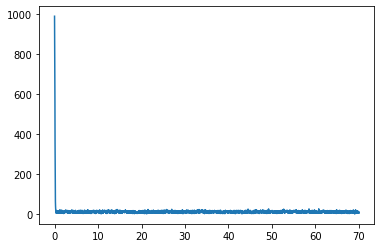

In [245]:
plt.plot(results[:,0], results[:,1])